# GRADIENTE DE TEMPERATURA

## Para ello vamos a utilizar los datos de radio presentados en los Papers Khan et al (2024), Wenger et al (2019) y Quieza et al (2006).

## DISTANCIAS HELIOCENTRICAS Y SUS ERRORES

- To determinate the heliocentric distances $d$ we'll use a rotation curve model Reid et al (2014) changing the distance to the galactic center (GC) to the actual value $\text{R}_0 = 8.2\text{kpc}$ with an uncertainty $\sigma \text{R}_0 = 0.1$. To determinate their uncertainties $\sigma \text{d}$ we'll use a Simulation MonteCarlo and use the percentiles de 16 y 84 where is lower and upper uncertaintinty.


- Note: The rotation curve model has a problem that is know as kinematic distance ambiguity (KDA), the model return three possible values for the distance; Near, Far and Tangent, to avoid this problem we take the minimun diffirent between the possible values and the value published in the paper.


- We use the heliocentric distance to determinate the galactocentric radius  with their uncertaintinies. We use the astropy librery 

In [1]:
#IMPORTAMOS LAS LIBRERIAS A UTILIZAR
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.coordinates import Distance
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic
from astropy.coordinates import Galactocentric
from astropy.modeling import models, fitting
import astropy.units as u

from astroquery.utils.tap.core import TapPlus

from scipy import stats
from scipy.optimize import minimize
from scipy import odr


from urllib.error import HTTPError


from multiprocessing import Pool, cpu_count

$$V_{helio} = V_{LSR} - (U^{Std}_{\odot} cos(l) + V^{Std}_{\odot}sin(l))cos(b) - W^{Std}_{\odot}sin(b)$$

Ahora vamos a usar los nuevos parametros para derivar $V^{Rev}_{LSR}$ usando:

$$V^{Rev}_{LSR} = V_{helio} + (U^{Rev}_{\odot} cos(l) + V^{Rev}_{\odot}sin(l))cos(b) - W^{Rev}_{\odot}sin(b)$$

Para estimar los errores usaremos la siguente ecuación:

$$\sigma ^{Rev2}_{V} = \sigma ^{2}_{V} + (\sigma^{Rev}_{U_{\odot}}cos(l)cos(b)) ^2 + (\sigma^{Rev}_{V_{\odot}} sin(l)cos(b))^2 + (\sigma^{Rev}_{W_{\odot}} sin(b))^2 $$

Revisar el paper Wenger et al (2018) para más información.

### Vamos a definar las funciones Importantes para el Modelo de Curva de Rotación:

Dicho modelo nos retornará d_near, d_far y d_tan

In [2]:
### These functions return the modificated velocities of V_lsr with their errors for the rotation curve Reid et al (2014)

### Important parametres:

## Velocity of the Local Standar of Rest:V_LSR
## Galactic longitude:l
## Galatic Lontitud: b

#Definimos una función que nos retorna V_helio a partir de V_lsr, l y b:

def V_helio(V_lsr, l, b, U_std = 10, V_std = 15,W_std = 7):
    
    """"
    We calculate the V_helio
    Parametres:
        V_lsr: Array 1D of Velocity of the Local Standard of Rest
        l: Array 1D of the Galactic Longitud
        b:  Array 1D of the Galatic Latitud
        U_std, V_std, W_std: Standard parametres of the solar motion
    Return:
        V_helio_ Array 1D of the Heliocentric Velocity
    """
        
    V_helio = V_lsr - (U_std*np.cos(l) + V_std*np.sin(l))*np.cos(b) - W_std*np.sin(b)
    
    return V_helio

#Definimos V^{Rev}_{LSR} que es nuestra nueva función para V_lsr:

def VrevLSR(V_lsr, l, b, U_rev = 10.5, V_rev = 14.4, W_rev = 8.9):
    
    """"
    We calculate the the New V_lsr
    Parametres:
        V_lsr: Array 1D of Velocity of the Local Standard of Rest
        l: Array 1D of the Galactic Longitud
        b:  Array 1D of the Galatic Latitud
        U_std, V_std, W_std: Standard parametres of the solar motion
    Return:
        VrevLSR: Array 1D of the new Velocity of the Local Standard of Rest
    """
    
    V_Rev_LSR = V_helio(V_lsr, l, b) + (U_rev*np.cos(l) + V_rev*np.sin(l))*np.cos(b) + W_rev*np.sin(b)
    
    return V_Rev_LSR

#Definimos nuestra ecuación de propagación de errores:

def e_VrevLSR(e_Vlsr, l, b, e_U_rev = 1.7, e_V_rev = 6.8, e_W_rev = 0.9):
    
    """"
    We calculate the error of VrevLSR
    Parametres:
        V_lsr: Array 1D of Velocity of the Local Standard of Rest
        l: Array 1D of the Galactic Longitud
        b:  Array 1D of the Galatic Latitud
        e_U_std, e_V_std, e_W_std:  Errors in the Standard parametres of the solar motion
    Return:
        V_helio: Array 1D of the Heliocentric Velocity
    """
    
    eVrev2 = e_Vlsr**2 + (e_U_rev*np.cos(l)*np.cos(b))**2 + (e_V_rev*np.sin(l)*np.cos(b))**2 + (e_W_rev*np.sin(b))**2
    eVrev = np.sqrt(eVrev2)
    
    return eVrev

In [7]:
### Importamos funciones importantes:
#Calculamos en orden, Rgal, az, Dsun, glon


"""
Here we used the public code made by Wenger in 2018 for their article "Kinematic Distances: A Monte Carlo Method"
Available here: https://zenodo.org/records/1166001
We thanks to Wenger. 

"""
def calc_Rgal(glong, dist, R0=8.2): #Calcula el R a partir de l y d
    
    """ 
    We calculate the Galactocentric radius
    Parametres:
        glong: Galoctic Longitude
        dist: Heliocentric Distance
        R0 =  Distance to the Galactic Center equals 8.2
    Return:
        Rgal: Galactocentric Radius
    """
    glong, dist = np.atleast_1d(glong, dist)
    
    Rgal2 = R0**2. + dist**2.
    Rgal2 = Rgal2 - 2.*R0*dist*np.cos(np.deg2rad(glong))
    Rgal = np.sqrt(Rgal2)
    return Rgal

def calc_az(glong, dist, R0=8.2): #Calcula az a partir de l y d
    
    """
    We calculate the theta azimut
    Parametres:
        glong: Galatic Longitude
        dist: Heliocentric Distance
        R0: Distance to the Galactic Center equals 8.2
    
    Return:
        Theta Azimut: Galactocentric azimuth of an object
    """ 
    
    glong, dist = np.atleast_1d(glong, dist)
    
    Rgal = calc_Rgal(glong,dist,R0=R0) #Llamamos la función anterior para determinar R a partir de l y d
    Rgal = np.atleast_1d(Rgal)
    
    cos_az = (R0**2. + Rgal**2. - dist**2.)/(2.*Rgal*R0) #Calculamos el cos(az) a partir de R
    
    # Catch fringe cases
    cos_az[cos_az > 1.] = 1.
    cos_az[cos_az < -1.] = -1.
    
    az = np.rad2deg(np.arccos(cos_az))
    
    # Correct azimuth in 3rd and 4th quadrants
    az[glong > 180.] = 360. - az[glong > 180.]
    
    return az

def calc_dist(az, Rgal, R0=8.2): #Retorna d a partir de az y R
    
    """
    We calculate the Heliocentric distance using the Galactocentric raidus and the theta azimut
    Parametres:
        az: Galactocentric azimut of an object
        Rgal: Galactocentric Radiuos of an object
        R0: Distance to the Galactic Center
    Return:
        dist: Heliocentric Distance
    """    
    
    az, Rgal = np.atleast_1d(az, Rgal)
        
    dist2 = R0**2. +Rgal**2.
    dist2 = dist2 - 2.*R0*Rgal*np.cos(np.deg2rad(az))
    dist = np.sqrt(dist2)
    
    return dist

def calc_glong(az, Rgal, R0=8.2): #Retorna l a partir de az y R
    
    """
    We calculate the galactic longitude using the theta azimut and the galactocentric radius
    Parametres:
        az: Theta azimut of an object
        Rgal: Galactocentric Radius 
        R0: Distance to the Galactic Center (GC)
    Return:
        glong: Galactic Longitude
    """
    
    az, Rgal = np.atleast_1d(az, Rgal)
    
    az = az % 360.
    
    dist = calc_dist(az,Rgal,R0=R0) #Usamos la función anterior para determinar d
    dist = np.atleast_1d(dist)
    
    # law of cosines
    #
    cos_glong = (R0**2. + dist**2. - Rgal**2.)/(2.*dist*R0)
    #
    # Catch fringe cases
    #
    cos_glong[cos_glong > 1.] = 1.
    cos_glong[cos_glong < -1.] = -1.
    glong = np.rad2deg(np.arccos(cos_glong))
    #
    # Correct longitude in 3rd and 4th quadrants
    #
    glong[az > 180.] = 360. - glong[az > 180.]
    
    return glong

### Curva de rotación de Reid 2014:

Modelo de curva de rotación universal $\Theta(R)$ velocidad de rotación:

$$ \Theta (R) = a_1 \left[ \dfrac{1.97\beta x^{1.22}}{(x^2 + 0.78^2)^{1.43}}  + (1- \beta)x^2 \dfrac{1+a_3^2}{x^2 + a_3^2}   \right]^{1/2} $$

Donde $x = R/(a_2R_0)$ y $\beta = 0.72 + 0.44 \log_{10}\left[(a_3/1.5)^5\right] $ y las $a_i$ son parametros del modelo.

Tambien tenemos la velocidad del local standar of rest:

$$ V_{LSR}  = R_0 sin(l) \left[ \dfrac{\Theta(R)}{R} - \dfrac{a_1}{R_0} \right]  $$

In [4]:
### Modelo de Curva de Rotación de Reid et al (2014)
### ESTE MODELO SERA BASE PARA PODER ESTIMAR NUESTRAS DISTANCIAS
### ESTA FUNCION NOS RETORNA V_lsr y los parametros

""""
Utilities involving the Universal Rotation Curve (Persic+1996) from Reid+2014.
Here we use the Universal Rotation Curve of Persic+1996 using the actual parametres of the solar motion by Reid 2014
We used R0 = 8.2 instead of R0 = 8.34 with an incertanties R0_err = 0.1
""""

__a1 = 241. # km/s V(R_opt)
__a1_err = 8.
__a2 = 0.90 # R_opt/ R0
__a2_err = 0.06
__a3 = 1.46 # 1.5*(L/L*)^0.2
__a3_err = 0.16
__R0 = 8.2 # kpc
__R0_err = 0.1

#Esta función nos determina Theta (Velocidad Rotacional del modelo):

def calc_theta_Reid(R,a1=__a1,a2=__a2,a3=__a3,R0=__R0,resample=True):
    """
    Return circular orbit speed theta at given Galactocentric radius
    R.

    Parameters:
      R : scalar or 1-D array
          Galactocentric radius (kpc)
      a1,a2,a3 : scalars (optional)
                 Reid+2014 rotation curve parameters
      R0 : scalar (optional)
           Solar Galactocentric radius (kpc)

    Returns: theta
      theta : scalar or 1-D array
              circular orbit speed at R (km/s)
    """
    
    # convert scalar to array if necessary
    R = np.atleast_1d(R)
    #
    # Resample rotation curve parameters if necessary
    #
    if resample:
        # resample fit parameters within uncertainty
        a1 = np.random.normal(loc=__a1,scale=__a1_err)
        a2 = np.random.normal(loc=__a2,scale=__a2_err)
        a3 = np.random.normal(loc=__a3,scale=__a3_err)
        R0 = np.random.normal(loc=__R0,scale=__R0_err)
        
    #Ecuaciones del Modelo
    x = R/(a2 * R0)
    LLstar = (a3/1.5)**5.
    beta = 0.72 + 0.44*np.log10(LLstar)
    
    # Disk component Vd^2 / V(R_opt)^2
    Vd2 = beta * 1.97 * x**1.22 / (x**2. + 0.78**2.)**1.43
    # Halo component Vh^2 / V(R_opt)^2
    Vh2 = (1.-beta)*(1.+a3**2.)*x**2./(x**2. + a3**2.)
    #
    # Catch non-physical case where Vd2 + Vh2 < 0
    #
    Vtot = Vd2 + Vh2
    Vtot[Vtot < 0.] = np.nan
    #
    # Circular velocity
    #
    theta = a1 * np.sqrt(Vtot)
    return theta

#Esta función determina las velocidades del local standar of rest del modelo:

def calc_vlsr_Reid(glong, dist, resample=True):
    """
    Return the LSR velocity at a given Galactic longitude and
    line-of-sight distance.
    If requested, resample rotation curve parameters and R0 within
    uncertainties assuming Gaussian errors.

    Parameters:
      glong : scalar or 1-D array
              Galactic longitude (deg). If it is an array, it must
              have the same size as dist.
      dist : scalar or 1-D array
             line-of-sight distance (kpc). If it is an array, it must
             have the same size as glong or glong must be a scalar.
      resample : bool (optional)
                 if True, resample rotation curve parameters within
                 uncertainties

    Returns: vlsr, params
      vlsr : scalar or 1-D array
             LSR velocity (km/s). If dist is a scalar, it
             is a scalar. Otherwise it has shape (dist.size).

      params : dict of scalars
        parameters used to calculate vlsr (useful if resample is True)
        params["R0"] : R0 used in calculation
        params["a1"] : a1 used in calculation
        params["a2"] : a2 used in calculation
        params["a3"] : a3 used in calculation
    """
    
    # convert scalar to array if necessary
    glong, dist = np.atleast_1d(glong, dist)
    # Resample rotation curve parameters if necessary
    #
    if resample:
        # resample fit parameters within uncertainty
        a1 = np.random.normal(loc=__a1,scale=__a1_err)
        a2 = np.random.normal(loc=__a2,scale=__a2_err)
        a3 = np.random.normal(loc=__a3,scale=__a3_err)
        R0 = np.random.normal(loc=__R0,scale=__R0_err)
        
    else:
        a1 = __a1
        a2 = __a2
        a3 = __a3
        R0 = __R0
    params = {"R0":R0,"a1":a1,"a2":a2,"a3":a3}
    
        # Convert distance to Galactocentric radius, catch places where
    # R = 0.
    #
    Rgal = calc_Rgal(glong,dist,R0=R0)
    Rgal = np.atleast_1d(Rgal)
    Rgal[Rgal < 1.e-6] = 1.e-6
    #
    # Reid rotation curve circular velocity
    #
    theta = calc_theta_Reid(Rgal,a1=a1,a2=a2,a3=a3,R0=R0)
    #
    # Now take circular velocity and convert to LSR velocity
    #
    vlsr = R0 * np.sin(np.deg2rad(glong))
    vlsr = vlsr * ((theta/Rgal) - a1/R0)
    #
    # Convert back to scalar if necessary
    #
    if dist.size == 1:
        return vlsr[0],params
    else:
        return vlsr,params

### Determinar Rgal, d_near, d_far, d_tan and vlsr_tangent a partir de $l$ y $V_{LSR}$: 

In [5]:
#Determinar Rgal, d_near, d_far, d_tan and vlsr_tangent a partir de glong y Vlsr

dist_rest = 1e-3 # Valor entre las distancias Heliocentricas del Modelo
dist_min = 1e-2 # Distancia Minima del Modelo
dist_max = 25 # Distancia Maxima del Modelo
Rgal_list = [] # Valores de Rgal del Modelo
Rtan_list = [] # Valores de Rtan del Modelo
near_list = [] # Valores dnear del modelo
far_list = [] # Valores dfar del modelo
tangent_list = [] # Valores dtan del modelo
vlsrtangent_ls = [] # Valores V_lsrtan del modelo

#Esta función determina los valores centrales anteriormente mencionados usando la Curva de Rotación de Reid.

def rotcurve(glong, vlsr_m, velo_tol = 1e-1, resample = True):
    """
    Return the kinematic near, far, and tanget distance for a
    given Galactic longitude and LSR velocity assuming
    a given rotation curve.

    Parameters:
      glong : scalar or 1-D array
              Galactic longitude (deg). If it is an array, it must
              have the same size as velo.
      velo : scalar or 1-D array
             LSR velocity (km/s). If it is an array, it must
             have the same size as glong.
      velo_tol : scalar (optional)
                 LSR velocity tolerance to consider a match between
                 velo and rotation curve velocity
      rotcurve : string (optional)
                 rotation curve model
      dist_res : scalar (optional)
                 line-of-sight distance resolution when calculating
                 kinematic distance (kpc)
      dist_min : scalar (optional)
                 minimum line-of-sight distance when calculating
                 kinematic distance (kpc)
      dist_max : scalar (optional)
                 maximum line-of-sight distance when calculating
                 kinematic distance (kpc)
      resample : bool (optional)
                 if True, resample rotation curve parameters within
                 uncertainties
    
    Returns: output
      #output["Rgal"] : scalar or 1-D array
                       Galactocentric radius (kpc).
      #output["Rtan"] : scalar or 1-D array
                       Galactocentric radius of tangent point (kpc).
      output["near"] : scalar or 1-D array
                       kinematic near distance (kpc)
      output["far"] : scalar or 1-D array
                      kinematic far distance (kpc)
      output["tangent"] : scalar or 1-D array
                          kinematic tangent distance (kpc)
      #output["vlsr_tangent"] : scalar or 1-D array
                               LSR velocity of tangent point (km/s)
      If glong and velo are scalars, each of these is a scalar.
      Otherwise they have shape (velo.size).
      """
    
    glong, vlsr_m = np.atleast_1d(glong, vlsr_m) #Convertir a np.array 1D
    
    glong = glong%360 #360 grados l
    
    dist = np.arange(dist_min, dist_max, dist_rest) #Arreglo de distancias Heliocentricas
    
    #Modelo de curva de rotación:
    
    vlsrs = np.zeros((glong.size, dist.size)) #
    params = [None]*glong.size
    
    for ind,l in enumerate(glong):
        vlsr,param = \
        calc_vlsr_Reid(l,dist,resample=resample) #Se llama a la función definida para la curva de rotación
        vlsrs[ind] = vlsr # Para cada ind de l se asigna una velocidad
        params[ind] = param # Para cada  ind de l se asigna un parametro
        
    # Storage for kinematic distance indicies
    #
    near_ind = np.ma.masked_all(vlsr_m.size,dtype=np.int64)
    far_ind = np.ma.masked_all(vlsr_m.size,dtype=np.int64)
    tan_ind = np.ma.masked_all(glong.size,dtype=np.int64)
    
    #Calculo de la distancia
    
    for i,(l,v) in enumerate(zip(glong,vlsr_m)):
        
        # 2nd or 3rd quadrants
        #
        if (90. <= l <= 270.):
            #
            # far distance indicies, solo obtenemos far porque en estos cuadrantes estamos lejos
            #
            velo_diff = np.min(np.abs(vlsrs[i] - v))
            best_ind = np.argmin(np.abs(vlsrs[i] - v))
            if velo_diff < velo_tol:
                far_ind[i] = best_ind
        #
        # 1st or 4th quadrants
        #
        else:
            #
            # tangent distance indicies
            #
            if l <= 90.: tan_ind[i] = np.argmax(vlsrs[i])
            if l >= 270.: tan_ind[i] = np.argmin(vlsrs[i])
            # mask if tangent distance is zero
            if tan_ind[i] == 0:
                tan_ind.mask[i] = True
                continue
            #
            # near distance indicies
            #
            velo_diff = np.min(np.abs(vlsrs[i,0:tan_ind[i]]-v))
            best_ind = np.argmin(np.abs(vlsrs[i,0:tan_ind[i]]-v))
            if velo_diff < velo_tol:
                near_ind[i] = best_ind
            #
            # far distance indicies
            #
            velo_diff = np.min(np.abs(vlsrs[i,tan_ind[i]:]-v))
            best_ind = np.argmin(np.abs(vlsrs[i,tan_ind[i]:]-v))
            best_ind += tan_ind[i]
            if velo_diff < velo_tol:
                far_ind[i] = best_ind
                
    # Assign distances from indicies, mask where appropriate
    #
    near_dist = np.array([dist[ind] if ind is not np.ma.masked
                          else np.nan for ind in near_ind])
    far_dist = np.array([dist[ind] if ind is not np.ma.masked
                         else np.nan for ind in far_ind])
    #Rgal = np.array([calc_Rgal(l,d,R0=params[ind]["R0"])
    #                 for ind,(l,d) in
     #                enumerate(zip(glong,far_dist))])
    tan_dist = np.array([dist[ind] if ind is not np.ma.masked
                         else np.nan for ind in tan_ind])
    #Rtan = np.array([calc_Rgal(l,d,R0=params[ind]["R0"])
     #                for ind,(l,d) in
      #               enumerate(zip(glong,tan_dist))])
    #
    # Assign tangent point velocities
    #
    #vlsr_tan = np.array([vlsrs[i][t] if t is not np.ma.masked
     #                    else np.nan for i,t in enumerate(tan_ind)])
        
    
    #
    # Convert back to scalars if necessary
    #
    if len(glong) == 1:
        return {"near":near_dist[0], #"Rgal":Rgal[0], "Rtan":Rtan[0],
                "far":far_dist[0], "tangent":tan_dist[0] }
                #"vlsr_tangent":vlsr_tan[0]}
    else:
        #Concatenar:
        
        #Rgal = np.append(Rgal_list,Rgal)
        #Rtan = np.append(Rtan_list, Rtan)
        near_dist = np.append(near_list, near_dist)
        far_dist = np.append(far_list, far_dist)
        tan_dist = np.append(tangent_list, tan_dist)
        #vlsr_tan = np.append(vlsrtangent_ls, vlsr_tan)
        
        return {"near":near_dist, #"Rgal":Rgal, "Rtan":Rtan,
                "far":far_dist, "tangent":tan_dist}
                #"vlsr_tangent":vlsr_tan}

In [87]:
## Esta función retorna los peaks en las distancias y estima tambien sus errores en distancias: near, far y tangent
## Esta función a diferencia de la de arriba retorna los NaN en los indeces correspondientes, así no tendremos problemas 
## Al reasignarlos a las tablas.

def _rotcurve_kd_worker(num_samples, glong=None, velo=None, velo_err=None, rotcurve_dist_res=1.e-2,
                        rotcurve_dist_max=30, pool = None):
    """
    Estimate heliocentric distances (near, far, tangent) and their asymmetric errors using Monte Carlo simulation.
    Here we use the median and the percentiles 16 and 84 to estimate the asymmetric errors.

    Parameters:
        num_samples (int): Number of Monte Carlo samples.
        glong (Union[float, np.ndarray]): Galactic longitude(s) in degrees.
        velo (Union[float, np.ndarray]): Observed velocity/velocities in km/s.
        velo_err (Union[float, np.ndarray]): Uncertainty/uncertainties in the observed velocity/velocities.
        rotcurve_dist_res (float): Resolution for the rotation curve calculation.
        rotcurve_dist_max (float): Maximum distance for the rotation curve calculation.
        pool (Optional[Pool]): Multiprocessing pool for parallel computation.

    Returns:
        Dict[str, List[float]]: Dictionary containing peak distances and their asymmetric errors.
    """
    
    # Listas vacias para los resultados
    peak_near_list, peak_far_list, peak_tan_list = [], [], []
    em_near_list, ep_near_list, em_far_list, ep_far_list = [], [], [], []
    em_tan_list, ep_tan_list = [], []
    
    # Convertir a np.array de ser necesario:
    glong, velo = np.atleast_1d(glong, velo)
    
    # Remuestrear las velocidades usando una distribución Gaussiana:
    if velo_err is not None:
        velo_resample = np.random.normal(loc=velo, scale=velo_err, size=(num_samples, velo.size)).T
    else:
        velo_resample = np.ones((num_samples, velo.size)) * velo
    
    # Calculate kinematic distance for each l,v point
    kd_out = [rotcurve(np.ones(num_samples)*l, v, resample=True) for l, v in zip(glong, velo_resample)]
    
    # Function to remove NaNs but keep the indices intact
    def remove_nans_with_placeholder(data):
        nan_mask = np.isnan(data)  # Create a mask for NaN values
        data_clean = data[~nan_mask]  # Filter out NaN values
        return data_clean, nan_mask  # Return cleaned data and the NaN mask
    
    # Process distances using percentiles
    def process_distances(distances, mask):
        if distances.size > 1:
            median = np.median(distances)
            lower_bound = np.percentile(distances, 16)
            upper_bound = np.percentile(distances, 84)
            em = median - lower_bound
            ep = upper_bound - median
            return median, em, ep
        else:
            return np.nan, np.nan, np.nan
    
    # Initialize result lists
    peak_near_list, peak_far_list, peak_tan_list = [], [], []
    em_near_list, ep_near_list, em_far_list, ep_far_list = [], [], [], []
    em_tan_list, ep_tan_list = [], []
    
    # Iterate over results
    for i, l in enumerate(glong):
        
        #Near
        kd_outnear, near_mask = remove_nans_with_placeholder(kd_out[i]['near'])
        peak_near, em_near, ep_near = process_distances(kd_outnear, near_mask)
        peak_near_list.append(peak_near)
        em_near_list.append(em_near)
        ep_near_list.append(ep_near)
        
        #Far
        kd_outfar, far_mask = remove_nans_with_placeholder(kd_out[i]['far'])
        peak_far, em_far, ep_far = process_distances(kd_outfar, far_mask)
        peak_far_list.append(peak_far)
        em_far_list.append(em_far)
        ep_far_list.append(ep_far)
        
        #Tangent
        kd_outtan, tan_mask = remove_nans_with_placeholder(kd_out[i]['tangent'])
        peak_tan, em_tan, ep_tan = process_distances(kd_outtan, tan_mask)
        peak_tan_list.append(peak_tan)
        em_tan_list.append(em_tan)
        ep_tan_list.append(ep_tan)
    
    return {
        'd_near': peak_near_list, 'em_d_near': em_near_list, 'ep_d_near': ep_near_list,
        'd_far': peak_far_list, 'em_d_far': em_far_list, 'ep_d_far': ep_far_list,
        'd_tan': peak_tan_list, 'em_d_tan': em_tan_list, 'ep_d_tan': ep_tan_list
    }

#### FUNCIÓN PARA ESTIMAR EL VALOR MÁS CERCANO AL VALOR REPORTADO.

In [88]:
## ESTA FUNCIÓN ES IMPORTANTE:
## A esta función le doy mis valores de entrada MUY IMPORTANTE QUE SEAN IGUALES:
## 'near', 'far' and 'tan' con sus errores minimos y maximos asociados.

# Create the new columns with NaN handling and the difference threshold
def closest_distance_with_nan_and_threshold(row, col_name):
    
    if pd.isna(row[col_name]):
        return pd.Series([np.nan, np.nan, np.nan], index=['d_SunNew', 'em_d', 'ep_d'])
    
    distances = {'near': row['near'], 'far': row['far'], 'tan': row['tan']}
    errors_minus = {'near': row['e_near'], 'far': row['e_far'], 'tan': row['e_tan']}
    errors_plus = {'near': row['E_near'], 'far': row['E_far'], 'tan': row['E_tan']}
    
    # Filter out NaN values from distances and errors
    valid_distances = {key: value for key, value in distances.items() if not pd.isna(value)}
    valid_errors_minus = {key: value for key, value in errors_minus.items() if not pd.isna(value)}
    valid_errors_plus = {key: value for key, value in errors_plus.items() if not pd.isna(value)}
    
    # If no valid distances are found, return NaN
    if not valid_distances:
        return pd.Series([np.nan, np.nan, np.nan], index=['d_SunNew', 'em_d', 'ep_d'])
    
    # Find the closest distance from the valid distances
    closest_key = min(valid_distances, key=lambda k: abs(valid_distances[k] - row[col_name]))
    closest_value = valid_distances[closest_key]
    
    # Check if the difference is greater than 5
    if abs(closest_value - row[col_name]) > 5:
        return pd.Series([np.nan, np.nan, np.nan], index=['d_SunNew', 'em_d', 'ep_d'])
    
    # Get the associated errors for the closest distance
    em_d = valid_errors_minus[closest_key]
    ep_d = valid_errors_plus[closest_key]
    
    
    return pd.Series([closest_value, em_d, ep_d], index=['d_SunNew', 'em_d', 'ep_d'])

### Ya definidas las funciones a utilizar, lo que haremos ahora es cargar los datos que se presetan en cada una de las tablas.

### Vamos a empezar con Quireza

Los datos de Quireza se encuentran dos tablas diferentes, Los datos de longitud galactica $l$ en la tabla 1 las velocidades de local standar of rest $V_{LSR}$ se presentan en la tabla 2 en Quireza et al (2006) RADIO RECOMBINATION LINES IN GALACTIC HII REGIONS.

Link: https://ui.adsabs.harvard.edu/abs/2006ApJS..165..338Q/abstract

Las distancias Heliocentricas $d$ se presentan en la tabla 1 en Quireza et al (2006) THE ELECTRON TEMPERATURE GRADIENT IN THE GALACTIC DISK.

Link: https://ui.adsabs.harvard.edu/abs/2006ApJ...653.1226Q/abstract

In [89]:
### Importamos los datos de Quireza 2006 'Radio Recombinación line in Galactic HII Regions'

VIZIER_TAP_URL = 'http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap'
viz = TapPlus(url=VIZIER_TAP_URL)

table = "J/ApJS/165/338/table1" # change the table

job = viz.launch_job_async(
    f"""SELECT TOP 10000 *
    FROM 
        "{table}"
   """,
    output_format="csv",
)
tab = job.get_results()
Quireza = tab.to_pandas()

VIZIER_TAP_URL = 'http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap'
viz = TapPlus(url=VIZIER_TAP_URL)

table = "J/ApJS/165/338/lines" # change the table

job = viz.launch_job_async(
    f"""SELECT TOP 10000 *
    FROM 
        "{table}"
   """,
    output_format="csv",
)
tab2 = job.get_results()
Quireza2 = tab2.to_pandas()
Quireza2 = Quireza2.head(119)

## IMPORTAMOS LOS DATOS DE QUIREZA ET AL (2006) THE ELECTRON TEMPERATURE GRADIENT IN THE GALACTIC DISK
#QUIREZA:
Quireza3 = pd.read_csv('result.csv', delimiter =",") #Quireza et al. (2006)

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [90]:
#Visualizamos tabla 1 , aquí tenemos glong, glat

#Visualizar tabla 1 con los datos que quiero:
Quireza = Quireza[['Name','GLON', 'GLAT']]

#Visualizamos tabla 2, aquí tenemos V_lsr y e_Vlsr

Quireza2 = Quireza2[['Name','El', 'VLSR', 'e_VLSR']]

#Visualizamos tabla 3, aquí tenemos la distancia Heliocentrica.

Quireza3 = Quireza3[['Source','_RA', '_DE', 'RGal', 'dSun', 'Te', 'e_Te']]

#Vamos a calcular VrevLSR y sus errores y agregarlos a la tabla Quireza2 donde se encuentran las velocidades

Quireza2['Vrev'] = VrevLSR(Quireza2['VLSR'], Quireza['GLON'], Quireza['GLAT'] )
Quireza2['e_Vrev'] = e_VrevLSR(Quireza2['e_VLSR'], Quireza['GLON'] , Quireza['GLAT'])

In [91]:
#Vamos a calcular las distancias d_near, d_far y d_tan con sus errores y los vamos a agregar a Quireza3 para visualizar los datos

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
with Pool(processes=15) as pool:
    d = _rotcurve_kd_worker(1000, Quireza['GLON'], Quireza2['Vrev'], Quireza2['e_Vrev'], pool = pool)

16 CPUs


<IPython.core.display.Javascript object>


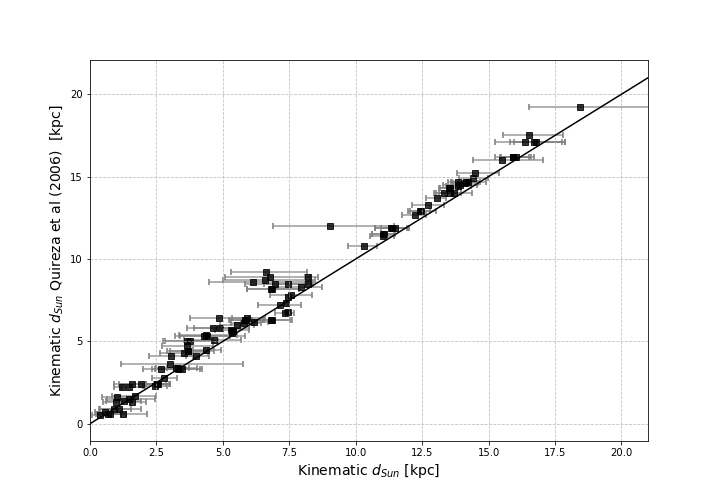

In [98]:
#Vamos a asignar nuestros resultados, 'near', 'far' and 'tan' with their errors to the Quireza3 DatFrame because is this Df
# We have our dSun distance and we can see and compare the values.

Quireza3['near'], Quireza3['e_near'], Quireza3['E_near'], Quireza3['far'], Quireza3['e_far'], Quireza3['E_far'], Quireza3['tan'], Quireza3['e_tan'], Quireza3['E_tan'] = d['d_near'], d['em_d_near'], d['ep_d_near'], d['d_far'], d['em_d_far'], d['ep_d_far'], d['d_tan'], d['em_d_tan'], d['ep_d_tan']


#Now We're gonna applied the closest_distance_with_nan function to Quireza3 and see the 50 first results:

Quireza3[['d_SunNew', 'em_d', 'ep_d']] = Quireza3.apply(lambda row: closest_distance_with_nan_and_threshold(row, 'dSun'), axis=1)
#Quireza3 = Quireza3.drop(['near', 'e_near', 'E_near', 'far', 'e_far', 'E_far', 'tan', 'e_tan', 'E_tan'], axis = 1)

#Vamos a crear una nueva tabla que contenga todos nuestros datos importantes:

Data_Quireza = {'Name': Quireza['Name'], 'GLON': Quireza['GLON'], 'GLAT': Quireza['GLAT'], 'V_lsr': Quireza2['VLSR'],
                'e_V_lsr': Quireza2['e_VLSR'] ,'Vrev': Quireza2['Vrev'], 'e_Vrev': Quireza2['e_Vrev'], '_RA': Quireza3['_RA'],
                '_DE': Quireza3['_DE'], 'RGal': Quireza3['RGal'], 'dSun': Quireza3['dSun'], 'Te': Quireza3['Te'],
                'e_Te': Quireza3['e_Te'], 'dSun_new': Quireza3['d_SunNew'], 'em_d': Quireza3['em_d'], 'ep_d': Quireza3['ep_d']}
                
df_Quireza = pd.DataFrame(Data_Quireza)

#Grafico
fig, ax = plt.subplots(figsize = (10,7))

ax.plot(np.linspace(0,21), 1*np.linspace(0,21), c = 'k') #Linea Recta
ax.errorbar(df_Quireza['dSun_new'], df_Quireza['dSun'], xerr =[Quireza3['em_d'], Quireza3['ep_d']], c = 'k', fmt = 's',
           capsize = 3, capthick = 2, ecolor = 'gray', label = 'Data', alpha = 0.8, zorder = 1)

ax.set_xlabel(r'Kinematic $d_{Sun}$ [kpc]', size = 14)
ax.set_ylabel(r'Kinematic $d_{Sun}$ Quireza et al (2006)  [kpc]', size = 14)
ax.set_xlim(0,21)
ax.grid(True, linestyle = '--', alpha = 0.8)
plt.show()
plt.savefig('dSun_Quireza_Comparation', dpi = 300)

### Wenger 2019:

Para Wenger 2019. Para estos datos vamos a ser muy cuidadosos, para ellos vamos a dar la siguiente explicación:

Los datos recopilidos por Wenger son del VLA telescope

En la tabla 1 se presetan las 148 regiones principales, en donde tenemos los siguentes datos importantes: $RA$ y $DEC$.

De dichas 148 regiones 114 presentaron emisión de radio continua donde sus propiedades se presetan en la tabla 4.

De las 114 regiones 82 regiones que son las principales para nuestro estudio se presetanrion RRL, en la tabla 5 se presentan las propiedades medidas de dichas regiones las cuales son: $V^{P}_{LSR}$ y su error, $V^{T}_{LSR}$ y su error y el nombre de cada región.

En la tabla 6 se hace una mezcla de datos con otro paper el cual se llama "Azimuthal Metallicity Structure in the Milky Way Disk" obteniendo un total de 189 regiones en total, las cuales 46 las distancias son determinadas por Parallax y su referencia se presenta en la misma tabla. Nos quedan 143 regiones donde tenemos varios NaN's lo que nos resta un total de 120 regiones determinadas con Kinematic Distance.

En “Azimuthal Metallicity Structure in the Milky Way Disk” la tabla 3 se presentan varias regiones (221) con sus propiedades físicas incluyendo “Te” donde dichos datos fueron tomados con el 140 Foot Telescope y por el GBT.

Por ende la tabla 6 es una mezcla de esos 3 telescopios: VLA, 140 Foot y GBT.

Con el 140 Foot tenemos: 14 regiones
Con el GBT tenemos: 51
Con el VLA tenemos: 55

Con estas ultimas 55 regiones vamos a determinar sus distancias Heliocentrias ya que estan son las que presetan nuestro paper.

El resto queda para despues, si es posible.

In [18]:
### IMPORTAMOS LAS 3 TABLAS DE WENGER:
VIZIER_TAP_URL = 'http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap'
viz = TapPlus(url=VIZIER_TAP_URL)

table = "J/ApJ/887/114/table1" # change the table

job = viz.launch_job_async(
    f"""SELECT TOP 10000 *
    FROM 
        "{table}"
   """,
    output_format="csv",
)
tab = job.get_results()
Wenger = tab.to_pandas()



VIZIER_TAP_URL = 'http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap'
viz = TapPlus(url=VIZIER_TAP_URL)

table = "J/ApJ/887/114/table5" # change the table

job = viz.launch_job_async(
    f"""SELECT TOP 10000 *
    FROM 
        "{table}"
   """,
    output_format="csv",
)
tab = job.get_results()
Wenger2 = tab.to_pandas()

VIZIER_TAP_URL = 'http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap'
viz = TapPlus(url=VIZIER_TAP_URL)

table = "J/ApJ/887/114/table6" # change the table

job = viz.launch_job_async(
    f"""SELECT TOP 10000 *
    FROM 
        "{table}"
   """,
    output_format="csv",
)
tab = job.get_results()
Wenger3 = tab.to_pandas()


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [19]:
#Seleccionar columnas con las que queremos trabajar con Wenger:

Wenger = Wenger[['Name', 'RAJ2000', 'DEJ2000']]
Wenger

,Name,RAJ2000,DEJ2000
0,G005.883-00.399,270.131250,-24.071917
1,G009.598+00.199,271.546250,-20.543472
2,G010.596-00.381,272.602500,-19.952333
3,G012.804-00.207,273.562500,-17.932333
4,G013.880+00.285,273.648750,-16.752694
...,...,...,...
143,G253.694-00.414,123.895417,-35.758417
144,G341.207-00.232,253.086250,-44.468556
145,G348.691-00.826,259.777500,-38.860472
146,G351.246+00.673,260.073750,-35.908111


In [20]:
#Seleccionar columnas que queremos con Wenger2

Wenger2 = Wenger2[['Name', 'VlsrP', 'e_VlsrP', 'VlsrT', 'e_VlsrT']]
Wenger2

,Name,VlsrP,e_VlsrP,VlsrT,e_VlsrT
0,G009.612+00.205,2.5,0.8,3.2,0.3
1,G009.613+00.200,4.0,0.1,3.8,0.1
2,G010.596-00.381,1.1,0.1,1.1,0.1
3,G010.621-00.380,-0.5,0.1,-0.7,0.1
4,G010.623-00.385,1.1,0.1,0.9,0.1
...,...,...,...,...,...
77,G135.188+02.701,-73.2,1.4,-72.2,2.8
78,G141.084-01.063,NaN,NaN,-25.2,1.3
79,G196.448-01.673,10.9,0.8,12.5,0.4
80,G351.246+00.673,-0.4,0.0,-0.1,0.0


In [21]:
#Seleccionar las columnas que quiero:

Wenger3 = Wenger3[['Name', 'Tel', 'Dist', 'e_Dist', 'E_Dist', 'Rad', 'e_Rad', 'E_Rad','Meth', 'Te', 'e_Te']]
Wenger3

,Name,Tel,Dist,e_Dist,E_Dist,Rad,e_Rad,E_Rad,Meth,Te,e_Te
0,G000.666-00.036,140 Foot,7.59,0.65,0.84,0.21,0.11,0.91,P,8170,180
1,G001.125-00.106,140 Foot,NaN,NaN,NaN,NaN,NaN,NaN,K,7130,70
2,G003.266-00.061,140 Foot,NaN,NaN,NaN,NaN,NaN,NaN,K,7440,280
3,G005.900-00.431,140 Foot,2.99,0.20,0.17,5.38,0.16,0.19,P,11130,170
4,G005.987-01.191,140 Foot,NaN,NaN,NaN,NaN,NaN,NaN,K,8180,70
...,...,...,...,...,...,...,...,...,...,...,...
184,G352.597-00.188,140 Foot,NaN,NaN,NaN,NaN,NaN,NaN,K,7560,240
185,G353.038+00.581,140 Foot,NaN,NaN,NaN,NaN,NaN,NaN,K,6250,30
186,G353.092+00.857,140 Foot,NaN,NaN,NaN,NaN,NaN,NaN,K,5630,40
187,G353.195+00.910,140 Foot,NaN,NaN,NaN,NaN,NaN,NaN,K,7100,40


In [22]:
##Vamos a limpiar bien nuestra tabla para solamente trabajar con los 55 datos que queremos:

#Filtramos  Las distancias cineticas:
Wenger_K = Wenger3[Wenger3['Meth'] == 'K']

#Aplicamos Mascara:
mask = ~np.isnan(Wenger3['Dist'])
Wenger_K = Wenger_K[mask]
#Nos retorna las 120 distancias cineticas, pero ocupamos trabajar solo con las 55 de VLA
print(len(Wenger_K))

120


<ipython-input-22-e17395de815f>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Wenger_K = Wenger_K[mask]


In [23]:
### Solo por curiosidad vamos a observar cuantos datos tienen los demas telescopios:

Foot = Wenger_K[Wenger_K['Tel'] == '140 Foot']
print('Los datos presentes con el telescopio 140 Foot son:',  len(Foot))

VLA = Wenger_K[Wenger_K['Tel'] == 'VLA']
print('Los datos presentes con el telescopio VLA son:', len(VLA), '(Con estos vamos a trabajar)')

GBT = Wenger_K[Wenger_K['Tel'] == 'GBT']
print('Los datos presentes con el telescopio GBT son:', len(GBT))

Los datos presentes con el telescopio 140 Foot son: 14
Los datos presentes con el telescopio VLA son: 55 (Con estos vamos a trabajar)
Los datos presentes con el telescopio GBT son: 51


In [24]:
### Para ello vamos a hacer dos Merge:

#Primer marge:

merged_df1 = Wenger.merge(Wenger2, on='Name')
merged_df1 #55

#Segundo marge:

merged_df2 = merged_df1.merge(Wenger_K, on = 'Name')

common_names = set(Wenger["Name"]) & set(Wenger2["Name"] ) & set(Wenger_K['Name']) 
print(len(common_names))

#Vamos a aplicar una mascara sobre V_lsrt

mask2 = ~np.isnan(merged_df2['VlsrT'])

merged_df2 = merged_df2[mask2]

43


In [25]:
#Calculamos l y b

#Calculamos glong
l = np.array([])
coord_l = SkyCoord(merged_df2['RAJ2000']*u.degree, merged_df2['DEJ2000']*u.degree).galactic.l.value
l = np.append(l, coord_l)

#Calculamos glat
b = np.asarray([]) 
coord_b = SkyCoord(merged_df2['RAJ2000']*u.degree, merged_df2['DEJ2000']*u.degree).galactic.b.value
b = np.append(b, coord_b)
    
merged_df2['GLON'], merged_df2['GLAT'] = l, b
merged_df2

## Velocidades y errores:

merged_df2['Vrev'] = VrevLSR(merged_df2['VlsrT'], l, b )
merged_df2['e_Vrev'] = e_VrevLSR(merged_df2['e_VlsrT'], l , b)
merged_df2 = merged_df2.drop(['VlsrP', 'e_VlsrP'], axis=1)
merged_df2

,Name,RAJ2000,DEJ2000,VlsrT,e_VlsrT,Tel,Dist,e_Dist,E_Dist,Rad,e_Rad,E_Rad,Meth,Te,e_Te,GLON,GLAT,Vrev,e_Vrev
0,G017.928-00.677,276.507083,-13.637389,38.4,1.0,VLA,12.65,0.37,0.37,5.41,0.31,0.23,K,6269,877,17.927993,-0.676978,37.817918,4.448040
1,G018.584+00.344,275.895417,-12.580194,14.3,0.9,VLA,14.36,0.39,0.42,7.02,0.31,0.25,K,5712,645,18.584067,0.343866,15.542995,2.471597
2,G019.728-00.113,276.855000,-11.781972,52.9,0.9,VLA,11.89,0.43,0.36,4.89,0.25,0.28,K,5813,629,19.727906,-0.112850,52.544345,5.387880
3,G020.363-00.014,277.067083,-11.173778,55.5,0.5,VLA,11.68,0.40,0.40,4.86,0.29,0.24,K,6150,367,20.362986,-0.013997,54.903117,6.807248
5,G023.661-00.252,278.828750,-8.359500,67.2,0.4,VLA,10.98,0.44,0.41,4.76,0.31,0.23,K,5583,318,23.661027,-0.252029,67.352291,6.570930
6,G025.397+00.033,279.378333,-6.685778,-14.0,0.2,VLA,16.40,0.47,0.66,9.53,0.38,0.55,K,7893,142,25.397882,0.033523,-13.611201,2.429210
7,G025.398+00.562,278.905833,-6.442778,11.5,0.3,VLA,14.11,0.36,0.41,7.49,0.28,0.28,K,7610,177,25.397962,0.562094,12.787824,2.126418
8,G027.562+00.084,280.330417,-4.739278,88.2,0.3,VLA,9.65,0.58,0.50,4.43,0.25,0.26,K,5765,261,27.562074,0.083840,87.591245,4.620748
9,G028.320+01.243,279.645417,-3.534667,-39.6,4.5,VLA,19.42,0.98,1.15,12.63,0.83,1.05,K,14189,2932,28.320042,1.242906,-37.953250,4.613579
10,G028.451+00.001,280.812083,-3.986389,-6.9,0.8,VLA,15.25,0.46,0.50,8.87,0.38,0.38,K,7576,629,28.451261,0.001099,-7.284504,2.207462


In [26]:
with Pool(processes=15) as pool:
    d2 = _rotcurve_kd_worker(1000, l, merged_df2['Vrev'], merged_df2['e_Vrev'], pool = pool)

Index 42, len(kd_outnear): 0
43 43 43 43


<IPython.core.display.Javascript object>


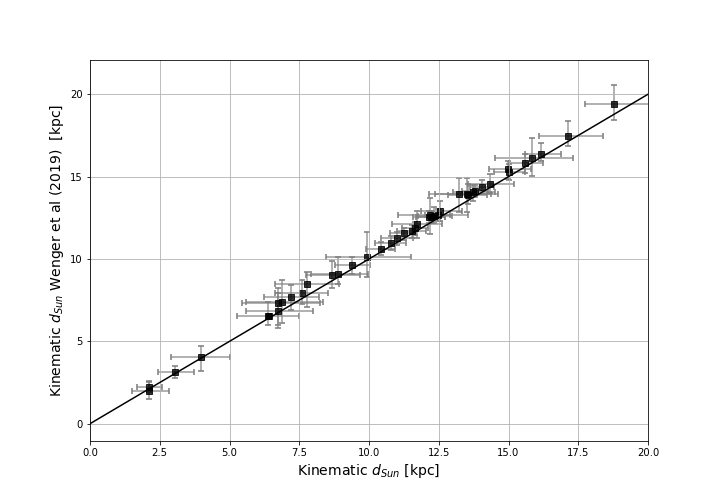

In [99]:
merged_df2['near'], merged_df2['e_near'], merged_df2['E_near'], merged_df2['far'], merged_df2['e_far'], merged_df2['E_far'], merged_df2['tan'], merged_df2['e_tan'], merged_df2['E_tan'] = d2['d_near'], d2['em_d_near'], d2['ep_d_near'], d2['d_far'], d2['em_d_far'], d2['ep_d_far'], d2['d_tan'], d2['em_d_tan'], d2['ep_d_tan']


#Now We're gonna applied the closest_distance_with_nan function to Quireza3 and see the 50 first results:

merged_df2[['d_SunNew', 'em_d', 'ep_d']] = merged_df2.apply(lambda row: closest_distance_with_nan_and_threshold(row, 'Dist'), axis=1)
merged_df2 = merged_df2.drop(['near', 'e_near', 'E_near', 'far', 'e_far', 'E_far', 'tan', 'e_tan', 'E_tan'], axis = 1)
merged_df2 = merged_df2.reset_index(drop = True)
merged_df2

#Grafico
fig, ax = plt.subplots(figsize = (10,7))

ax.plot(np.linspace(0,21), 1*np.linspace(0,21), c = 'k') #Linea Recta
ax.errorbar(merged_df2['d_SunNew'], merged_df2['Dist'], xerr =[merged_df2['em_d'],  merged_df2['ep_d']], 
            yerr = [merged_df2['e_Dist'], merged_df2['E_Dist']], c = 'k', fmt = 's',capsize = 3, capthick = 2, 
            ecolor = 'gray', label = 'Data', alpha = 0.8, zorder = 1)
ax.set_xlabel(r'Kinematic $d_{Sun}$ [kpc]', size = 14)
ax.set_ylabel(r'Kinematic $d_{Sun}$ Wenger et al (2019)  [kpc]', size = 14)
ax.set_xlim(0,20)
ax.grid(True)
plt.savefig('Dsun_Wenger_Comparation', dpi = 300)

### Khan 2024:

Los datos totales de Khan et al. (2024) son 244, de los cuales 29 no se pueden estimar sus distancias  debido a su ubicación muy cercana al CG $ -2 \le l \le 2 $, $ |b| \le 1 $ por tanto nos quedamos con 215 regiones.

De 244 regiones se compararon con otros estudios para obtener la distancia más fiable, se obtuvieron las distancias de la literuatura de 149 regiones entre $ 3 \le l \le 60$

De las 149 regiones de literatura tenemos que:

Regiones con distancia Parallax: 28 (Reid et al. 2019)

Regiones con distancia cinetica: 121 (Anderson & Bania 2009; Anderson et al. 2012; Urquhart et al. 2018)


Para 13 regiones se adopto una distancia de 1.4Kpc en dirección de Cygnus X
Para las 53 regiones restantes se determino usando Kinematic Distances.

In [33]:
### Importamos las tablas de Khan et al. (2024) y Reid et al. (2019)

#Khan:

VIZIER_TAP_URL = 'http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap'
viz = TapPlus(url=VIZIER_TAP_URL)

table = "J/A+A/689/A81/tablec1" # change the table

job = viz.launch_job_async(
    f"""SELECT TOP 10000 *
    FROM 
        "{table}"
   """,
    output_format="csv",
)
tab = job.get_results()
Khan = tab.to_pandas()

#Khan 2:

table2 = "J/A+A/689/A81/tablec2" # change the table

job2 = viz.launch_job_async(
    f"""SELECT TOP 10000 *
    FROM 
        "{table2}"
   """,
    output_format="csv",
)
tab2 = job2.get_results()
Khan2 = tab2.to_pandas()

#Reid:

VIZIER_TAP_URL = 'http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap'
viz = TapPlus(url=VIZIER_TAP_URL)

table = "J/ApJ/885/131/table1" # change the table

job = viz.launch_job_async(
    f"""SELECT TOP 10000 *
    FROM 
        "{table}"
   """,
    output_format="csv",
)
tab = job.get_results()
Reid = tab.to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [34]:
#Khan 1:
Khan = Khan[['Name', 'GLONpeak', 'GLATpeak', 'Vlsr', 'e_Vlsr', 'Dsun', 'e_Dsun', 'RGC', '_RA_icrs', '_DE_icrs']]

#Khan2
Khan2 = Khan2[['Name', 'Te', 'e_Te']]

#Mascara:

mask3 =  ~np.isnan(Khan['Dsun'])

Khan = Khan[mask3]
Khan2 = Khan2[mask3]

#Merge ambas tablas:

Khan = Khan.merge(Khan2, on = 'Name')
Khan

,Name,GLONpeak,GLATpeak,Vlsr,e_Vlsr,Dsun,e_Dsun,RGC,_RA_icrs,_DE_icrs,Te,e_Te
0,G003.350-0.077,3.350,-0.077,7.80,1.13,2.90,0.29,5.43,268.421,-26.102,6.5,0.7
1,G004.417+0.125,4.417,0.125,4.26,2.10,3.00,0.30,5.41,268.826,-25.079,6.6,1.0
2,G005.475-0.244,5.475,-0.244,21.45,0.99,11.90,1.19,3.87,269.762,-24.349,6.8,0.8
3,G005.907-0.427,5.907,-0.427,8.83,0.30,1.76,0.74,6.40,270.171,-24.065,7.6,0.5
4,G006.552-0.095,6.552,-0.095,11.96,0.30,14.10,1.41,6.07,270.206,-23.341,6.7,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...
210,G080.886+0.425,80.886,0.425,-0.87,1.90,1.40,0.00,8.05,309.229,41.627,6.6,1.3
211,G080.938-0.127,80.938,-0.127,-7.81,0.28,1.40,0.00,8.05,309.857,41.334,7.3,0.4
212,G080.940-0.267,80.940,-0.267,-5.50,2.13,1.40,0.00,8.05,310.007,41.250,8.6,1.8
213,G081.680+0.538,81.680,0.538,-1.47,0.29,1.40,0.00,8.07,309.755,42.327,8.0,0.4


In [35]:
## Calculamos las nuevas velocidades
Khan['Vrev'] = VrevLSR(Khan['Vlsr'], Khan['GLONpeak'], Khan['GLATpeak'] )
Khan['e_Vrev'] = e_VrevLSR(Khan['e_Vlsr'], Khan['GLONpeak'] , Khan['GLATpeak'])
Khan

,Name,GLONpeak,GLATpeak,Vlsr,e_Vlsr,Dsun,e_Dsun,RGC,_RA_icrs,_DE_icrs,Te,e_Te,Vrev,e_Vrev
0,G003.350-0.077,3.350,-0.077,7.80,1.13,2.90,0.29,5.43,268.421,-26.102,6.5,0.7,7.289886,2.449358
1,G004.417+0.125,4.417,0.125,4.26,2.10,3.00,0.30,5.41,268.826,-25.079,6.6,1.0,4.921996,6.806409
2,G005.475-0.244,5.475,-0.244,21.45,0.99,11.90,1.19,3.87,269.762,-24.349,6.8,0.8,21.747132,5.008844
3,G005.907-0.427,5.907,-0.427,8.83,0.30,1.76,0.74,6.40,270.171,-24.065,7.6,0.5,8.667046,2.733219
4,G006.552-0.095,6.552,-0.095,11.96,0.30,14.10,1.41,6.07,270.206,-23.341,6.7,0.4,12.101006,2.447768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,G080.886+0.425,80.886,0.425,-0.87,1.90,1.40,0.00,8.05,309.229,41.627,6.6,1.3,0.622641,4.949406
211,G080.938-0.127,80.938,-0.127,-7.81,0.28,1.40,0.00,8.05,309.857,41.334,7.3,0.4,-7.282723,4.740610
212,G080.940-0.267,80.940,-0.267,-5.50,2.13,1.40,0.00,8.05,310.007,41.250,8.6,1.8,-5.254762,5.067188
213,G081.680+0.538,81.680,0.538,-1.47,0.29,1.40,0.00,8.07,309.755,42.327,8.0,0.4,-0.066310,1.558207


In [36]:
#Vamos a calcular las distancias d_near, d_far y d_tan con sus errores y los vamos a agregar a Quireza3 para visualizar los datos

with Pool(processes=15) as pool:
    d3 = _rotcurve_kd_worker(1000, Khan['GLONpeak'], Khan['Vrev'], Khan['e_Vrev'], pool = pool)
#d3

Index 214, len(kd_outnear): 50
215 215 215 215


In [37]:
#Vamos a asignar nuestros resultados, 'near', 'far' and 'tan' with their errors to the Khan DatFrame because is this Df
# We have our Dsun distance and we can see and compare the values.

Khan['near'], Khan['e_near'], Khan['E_near'], Khan['far'], Khan['e_far'], Khan['E_far'], Khan['tan'], Khan['e_tan'], Khan['E_tan'] = d3['d_near'], d3['em_d_near'], d3['ep_d_near'], d3['d_far'], d3['em_d_far'], d3['ep_d_far'], d3['d_tan'], d3['em_d_tan'], d3['ep_d_tan']


#Now We're gonna applied the closest_distance_with_nan function to Quireza3 and see the 50 first results:

Khan[['d_SunNew', 'em_d', 'ep_d']] = Khan.apply(lambda row: closest_distance_with_nan_and_threshold(row, 'Dsun'), axis=1)
Khan = Khan.drop(['near', 'e_near', 'E_near', 'far', 'e_far', 'E_far', 'tan', 'e_tan', 'E_tan'], axis = 1)
Khan

,Name,GLONpeak,GLATpeak,Vlsr,e_Vlsr,Dsun,e_Dsun,RGC,_RA_icrs,_DE_icrs,Te,e_Te,Vrev,e_Vrev,d_SunNew,em_d,ep_d
0,G003.350-0.077,3.350,-0.077,7.80,1.13,2.90,0.29,5.43,268.421,-26.102,6.5,0.7,7.289886,2.449358,2.9430,0.80456,0.73656
1,G004.417+0.125,4.417,0.125,4.26,2.10,3.00,0.30,5.41,268.826,-25.079,6.6,1.0,4.921996,6.806409,NaN,NaN,NaN
2,G005.475-0.244,5.475,-0.244,21.45,0.99,11.90,1.19,3.87,269.762,-24.349,6.8,0.8,21.747132,5.008844,11.9825,0.67066,0.72546
3,G005.907-0.427,5.907,-0.427,8.83,0.30,1.76,0.74,6.40,270.171,-24.065,7.6,0.5,8.667046,2.733219,2.1940,0.62364,0.58400
4,G006.552-0.095,6.552,-0.095,11.96,0.30,14.10,1.41,6.07,270.206,-23.341,6.7,0.4,12.101006,2.447768,13.6985,0.51566,0.53330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,G080.886+0.425,80.886,0.425,-0.87,1.90,1.40,0.00,8.05,309.229,41.627,6.6,1.3,0.622641,4.949406,1.2980,0.01600,0.01700
211,G080.938-0.127,80.938,-0.127,-7.81,0.28,1.40,0.00,8.05,309.857,41.334,7.3,0.4,-7.282723,4.740610,1.2910,0.01500,0.01600
212,G080.940-0.267,80.940,-0.267,-5.50,2.13,1.40,0.00,8.05,310.007,41.250,8.6,1.8,-5.254762,5.067188,1.2920,0.01600,0.01700
213,G081.680+0.538,81.680,0.538,-1.47,0.29,1.40,0.00,8.07,309.755,42.327,8.0,0.4,-0.066310,1.558207,1.1870,0.01500,0.01300


<IPython.core.display.Javascript object>


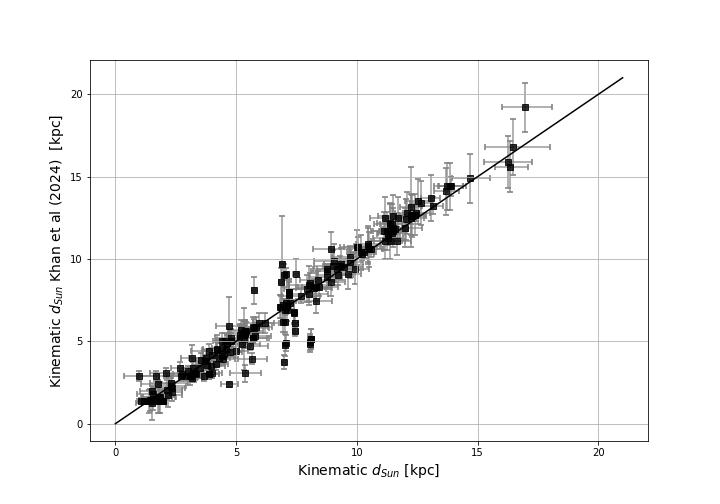

In [100]:
#Grafico
fig, ax = plt.subplots(figsize = (10,7))

ax.plot(np.linspace(0,21), 1*np.linspace(0,21), c = 'k') #Linea Recta
ax.errorbar(Khan['d_SunNew'], Khan['Dsun'], xerr =[Khan['em_d'],  Khan['ep_d']], yerr = Khan['e_Dsun'], c = 'k', 
            fmt = 's', capsize = 3, capthick = 2, ecolor = 'gray', label = 'Data', alpha = 0.8, zorder = 1)
ax.set_xlabel(r'Kinematic $d_{Sun}$ [kpc]', size = 14)
ax.set_ylabel(r'Kinematic $d_{Sun}$ Khan et al (2024)  [kpc]', size = 14)
ax.grid(True)
#plt.savefig('OurvsKhan', dpi = 500)
plt.savefig('Dsun_Khan_comparation', dpi = 300)

### AHORA VAMOS A ESTIMAR $R_{Gal}$ 

Ahora vamos a definir las funciones que estimen nuestros radios Galacticos y sus errores usando Metodo MonteCarlo:

In [40]:
# Esta función Calcula todas las R, nosotros le aportamos las coordenadas y el valor del centro Galactico

def R(RA,DEC, Dsun, GC):
    """
    We calculate the Galactocentric Radius using Right Ascension RA, Declination DEC, Heliocentric Distance and 
    Galactocentric Distance.
    
    Parametres: 
        RA: 1D array of the Right Ascension
        DEC: 1D array of the Declination
        Dsun: 1D array or Array of the Heliocentric Distance
        GC: 1D array of the Distance to the Galactic Center
    Return:
        R_C: Galactocentric Radius of an object
        
    """    
    GC_median = np.median(GC)
    GC_16 = np.percentile(GC, 16)
    GC_84 = np.percentile(GC, 84)
    
    
    
    rd = SkyCoord(ra = (RA)*u.degree, dec = (DEC)*u.degree, distance = (Dsun)*u.kpc , frame = 'icrs') #Coordenadas
    G_C_median = rd.transform_to(Galactocentric(galcen_distance = GC_median*u.kpc)) #Transformación
    G_C_16 = rd.transform_to(Galactocentric(galcen_distance = GC_16*u.kpc))
    G_C_84 = rd.transform_to(Galactocentric(galcen_distance = GC_84*u.kpc))
    
    R_C = np.sqrt( (G_C_median.x/3+G_C_16.x/3+G_C_84.x/3)**2 + (G_C_median.y/3+G_C_16.y/3+G_C_84.y/3)**2 + \
                 (G_C_median.z/3+G_C_16.z/3+G_C_84.z/3)**2  )
    
    return R_C

#Vamos a crear una Función que evalue los errores en las distancias galactocentricas usando errores en las distancias 
#Helio (e_Dist), (E_Dist) y errores en la distancia al Centro Galactico. Funciona si tiene errores minus & plus

def e_Rgal(RA, DEC, Dist, e_Dist, E_Dist):
    """
    We calculate the errors in the Galactocentric Radius of an object using a MonteCarlo Simulation.
    Parametres:
        RA: 1D Array of the Right Ascension
        DEC: 1D Array of the Declination
        Dist: 1D Array of the Heliocentric Distance
        e_Dist: 1D Array of the lower uncertainties in the Heliocentric Distance
        E_Dist: 1D Array of the upper uncertainties in the Heliocentric Distance
        
    Return:
        e_Rm_list2: 1D array of the lower uncertainties in the galactocentric radius
        e_Rp_list2: 1D array of the uppper uncertainties in the galactocentric radius
    """
    
    GC = 8.2 #Centro Galactico
    e_GC = 0.1 #Error en el Centro Galactico
    n_samples = 1000 #Número de muestras MonteCarlo
    e_Distance = (e_Dist + E_Dist)/2 #Usamos un error promedio de los datos plus y minus

    #Listas vacias:

    e_Rm_list2 = [] #Arreglo vacio que almacenará los datos del error minus
    e_Rp_list2 = [] #Arreglo vacio que almacenará los datos del error plus

    #Vamos a crear una serie de simulaciones MonteCarlo para cada row de nuestro dataframe:
    
    for i in range(len(Dist)):         
    
        #Hacemos una simulación MonteCarlo de 100000 muestras para cada Row de nuestro dataframe
    
        Dsun_samples = np.absolute(np.random.normal(Dist[i], e_Distance[i], n_samples)) #Simulación MonteCarlo para distancia Heliocentrica
        GC_samples = np.random.normal(GC, e_GC, n_samples) #Simulación MonteCarlo para error en la distancia al centro galactico
    
    
        #Calculos el Radio Galactocentrico:
    
        RGC_samples = R(RA[i], DEC[i], Dsun_samples, GC_samples).value #Llamamos a la función R para  determinar una distrubución Gaussiana de R
        
        peak_R = np.median(RGC_samples)
        
        
        #Calcular los percentiles 16th y 84th
        R_16th = np.percentile(RGC_samples, 16)
        R_84th = np.percentile(RGC_samples, 84)
    
        #Errores asimetricos:
    
        R_m = np.median(RGC_samples)
        e_Rm = R_m - R_16th
        e_Rp = R_84th - R_m
    
        #Concatenar:
    
        e_Rm_list2 = np.append(e_Rm_list2, np.absolute(e_Rm))
        e_Rp_list2 = np.append(e_Rp_list2, np.absolute(e_Rp))
    
    return e_Rm_list2, e_Rp_list2

### Quireza:

In [42]:
##Two nebulae, G49.582-0.38 (1851K,6.5 kpc) and G5.956-1.265 (3416 K, 7.8 kpc) have temperaturesmuch lower than the 7585 -1262 K
#average Te for the 6-8 kpc interval of RGal. Moreover, the G49.582-0.38 temperature is -3600Klower than theWWB83 value. 
#For these sources, we had to use TP continuummeasurements to derive Te . This mayhave compromised the accuracy of our result.
#G5.899-0.427 (11,128 K, 6.1 kpc) also lies far from the general trend of the sample

#Vamos a imprimir los index de los valores que vamos a eliminar:

print('Estos son los index donde el error es mayor a 4000 en Te:', df_Quireza.index[df_Quireza['e_Te'] > 4000].tolist()) #Error en la temperatura mayor a 4000
print('Estos son los index donde la temperatura es mayor a 20,000K:', df_Quireza.index[df_Quireza['Te'] > 20000].tolist()) #Te > 20000
print('Estos son los index para las regiones G49.582-0.38, G5.956-1.265 y G5.899-0.427:', df_Quireza.index[(df_Quireza['Name'] == 'G49.582-0.38') | (df_Quireza['Name'] =='G5.956-1.265') | (df_Quireza['Name'] == 'G5.899-0.427')].tolist())

# Vamos a eliminar esos datos 5 datos de nuestro df:

df_Quireza2 = df_Quireza.drop([5,6,55,65,86])
print(len(df_Quireza2))

Estos son los index donde el error es mayor a 4000 en Te: [65, 86]
Estos son los index donde la temperatura es mayor a 20,000K: [86]
Estos son los index para las regiones G49.582-0.38, G5.956-1.265 y G5.899-0.427: [5, 6, 55]
114


In [43]:
#Mascara: Se eliman los valores que tienen NaN en dSun_new
mask2 = ~np.isnan(df_Quireza2['dSun_new'])

df_Quireza2 = df_Quireza2[mask2]


#Reset index:
df_Quireza2 = df_Quireza2.reset_index(drop = True)

#Calcular Rgal:

R_Quireza = R(df_Quireza2['_RA'], df_Quireza2['_DE'], df_Quireza2['dSun_new'], GC = 8.2) #Quireza
df_Quireza2['Rgal'] = R_Quireza

#Calculamos glong
l = np.array([])
coord_l = SkyCoord(df_Quireza2['_RA']*u.degree, df_Quireza2['_DE']*u.degree).galactic.l.value
l = np.append(l, coord_l)

#Calculamos glat
b = np.asarray([]) 
coord_b = SkyCoord(df_Quireza2['_RA']*u.degree, df_Quireza2['_DE']*u.degree).galactic.b.value
b = np.append(b, coord_b)

    
df_Quireza2['l'], df_Quireza2['b'] = l, b
df_Quireza2

,Name,GLON,GLAT,V_lsr,e_V_lsr,Vrev,e_Vrev,_RA,_DE,RGal,dSun,Te,e_Te,dSun_new,em_d,ep_d,Rgal,l,b
0,G0.665-0.035,0.665,-0.035,64.31,0.17,64.266722,4.404790,266.82,-28.38,0.4,8.9,8170.0,180.0,8.2065,0.11050,0.09550,0.095394,0.664424,-0.022206
1,G1.13-0.1,1.119,-0.098,-19.91,0.07,-20.415867,6.134036,267.16,-28.03,0.1,8.5,7130.0,70.0,8.1930,0.09300,0.10300,0.160819,1.118915,-0.097806
2,G2.90+0.0,2.901,-0.003,-2.08,0.16,-2.714263,2.318797,268.10,-26.45,10.7,19.2,4840.0,140.0,18.6925,2.16182,2.95434,10.511242,2.903947,-0.005820
3,G3.270-0.101,3.270,-0.100,7.10,0.16,6.493359,1.897008,268.40,-26.18,5.5,14.0,7440.0,280.0,13.6520,0.59848,0.62316,5.485424,3.273147,-0.100183
4,G5.973-1.178,5.974,-1.178,2.69,0.07,1.186894,1.306797,270.90,-24.38,7.8,16.2,8180.0,70.0,15.9430,0.58100,0.59616,7.837176,5.961460,-1.160101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,G353.08+0.36,353.083,0.359,-2.75,0.11,-2.452048,6.022430,261.67,-34.57,7.9,0.6,5390.0,100.0,1.2190,0.80508,1.01020,6.991430,353.086515,0.352868
97,G353.14+0.66,353.136,0.662,-3.79,0.03,-2.961171,5.179063,261.40,-34.35,7.6,16.0,6250.0,30.0,15.4920,1.10032,1.54060,7.416643,353.144446,0.660446
98,G353.186+0.8,353.187,0.888,-3.71,0.05,-2.527833,4.231596,261.07,-34.33,7.6,0.9,7100.0,40.0,0.9940,0.61912,0.78312,7.214545,353.007962,0.897136
99,G353.398-0.3,353.399,-0.390,-16.15,0.06,-17.413099,6.296288,262.63,-34.72,5.2,3.3,8480.0,60.0,3.4125,0.97482,0.78094,4.826222,353.399226,-0.387716


In [44]:
#Calcular los errores:

e_RgalQuireza = e_Rgal(df_Quireza2['GLON'], df_Quireza2['GLAT'], df_Quireza2['dSun_new'], df_Quireza2['em_d'], df_Quireza2['ep_d'])
[df_Quireza2['e_Rm'], df_Quireza2['e_Rp']] = e_RgalQuireza[0], e_RgalQuireza[1]


<IPython.core.display.Javascript object>


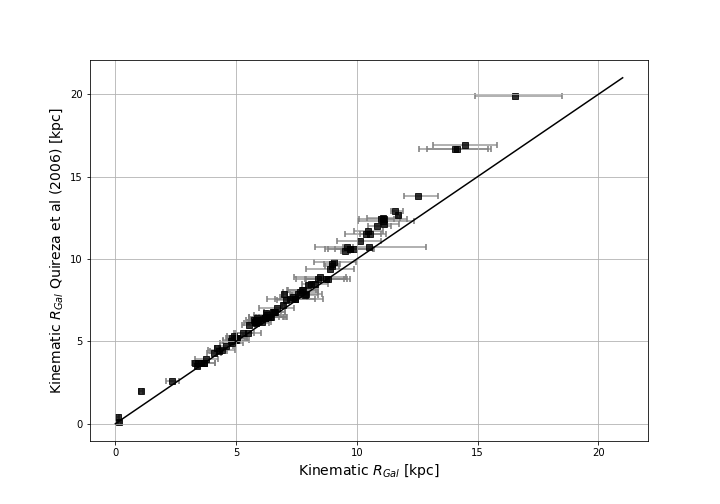

In [101]:
#Graficar:

fig, ax = plt.subplots(figsize = (10,7))

ax.plot(np.linspace(0,21), 1*np.linspace(0,21), c = 'k') #Linea Recta 
ax.errorbar(df_Quireza2['Rgal'], df_Quireza2['RGal'], xerr = [df_Quireza2['e_Rm'], df_Quireza2['e_Rp']], c = 'k', fmt = 's',
           capsize = 3, capthick = 2, ecolor = 'gray', label = 'Data', alpha = 0.8, zorder = 1)

ax.set_xlabel(r'Kinematic $R_{Gal}$ [kpc]', size = 14)
ax.set_ylabel(r'Kinematic $R_{Gal}$ Quireza et al (2006) [kpc]', size = 14)
ax.grid(True)
plt.show()
plt.savefig('Rgal_Quireza_Comparation', dpi = 300)

In [105]:
## Grafico Polar:

# Create a polar plot
fig, ax = plt.subplots(figsize = (10,8), subplot_kw={'projection': 'polar'})

r_1 = df_Quireza2['Rgal']
r_2 = df_Quireza2['RGal']
theta = np.deg2rad(df_Quireza2['l'])  # Adjust theta from the center
ax.scatter(theta, r_1, color='red', marker = '*' ,alpha = 0.8, label=' Our estimation')
ax.scatter(theta, r_2, color = 'blue', marker = '*', alpha = 0.8, label = 'Quireza et al (2006)')
ax.scatter(0, 8.2, s = 100, marker = '*', color = 'yellow', label = 'Sun')


# Set title and labels
ax.set_theta_zero_location('N') 
ax.set_theta_direction(-1) 
ax.set_rlim(0,21)
ax.set_title("Face-On Milky Way Galaxy")
ax.legend(loc = 'upper left')


plt.show()
plt.savefig('Face-On_Quireza', dpi = 300)

<IPython.core.display.Javascript object>

### Wenger:

Para Wenger vamos a hacer dos submuestras:

1) Muestra de 43 datos que ellos obtuvieron con el VLA.

2) Total de los 166 datos reportados en el paper.

#### Primera Muestra: Con esta vamos a determinar que tan buenas son nuestras estimaciones de $R_{Gal}$

In [48]:
#Calcular Rgal:

R_Wenger = R(merged_df2['RAJ2000'].values, merged_df2['DEJ2000'].values, merged_df2['d_SunNew'].values, GC = 8.2) #Quireza
merged_df2['Rgal'] = R_Wenger
merged_df2

,Name,RAJ2000,DEJ2000,VlsrT,e_VlsrT,Tel,Dist,e_Dist,E_Dist,Rad,...,Te,e_Te,GLON,GLAT,Vrev,e_Vrev,d_SunNew,em_d,ep_d,Rgal
0,G017.928-00.677,276.507083,-13.637389,38.4,1.0,VLA,12.65,0.37,0.37,5.41,...,6269,877,17.927993,-0.676978,37.817918,4.448040,12.4775,0.45482,0.44266,5.314750
1,G018.584+00.344,275.895417,-12.580194,14.3,0.9,VLA,14.36,0.39,0.42,7.02,...,5712,645,18.584067,0.343866,15.542995,2.471597,14.0430,0.42232,0.43348,6.793622
2,G019.728-00.113,276.855000,-11.781972,52.9,0.9,VLA,11.89,0.43,0.36,4.89,...,5813,629,19.727906,-0.112850,52.544345,5.387880,11.6505,0.47466,0.46998,4.808404
3,G020.363-00.014,277.067083,-11.173778,55.5,0.5,VLA,11.68,0.40,0.40,4.86,...,6150,367,20.362986,-0.013997,54.903117,6.807248,11.5260,0.53616,0.50616,4.782787
4,G023.661-00.252,278.828750,-8.359500,67.2,0.4,VLA,10.98,0.44,0.41,4.76,...,5583,318,23.661027,-0.252029,67.352291,6.570930,10.7845,0.57966,0.53166,4.642114
5,G025.397+00.033,279.378333,-6.685778,-14.0,0.2,VLA,16.40,0.47,0.66,9.53,...,7893,142,25.397882,0.033523,-13.611201,2.429210,16.1475,0.57198,0.72030,9.421101
6,G025.398+00.562,278.905833,-6.442778,11.5,0.3,VLA,14.11,0.36,0.41,7.49,...,7610,177,25.397962,0.562094,12.787824,2.126418,13.7945,0.46082,0.45966,7.291993
7,G027.562+00.084,280.330417,-4.739278,88.2,0.3,VLA,9.65,0.58,0.50,4.43,...,5765,261,27.562074,0.083840,87.591245,4.620748,9.3880,0.60828,0.62996,4.345653
8,G028.320+01.243,279.645417,-3.534667,-39.6,4.5,VLA,19.42,0.98,1.15,12.63,...,14189,2932,28.320042,1.242906,-37.953250,4.613579,18.7760,1.03256,1.30700,12.197159
9,G028.451+00.001,280.812083,-3.986389,-6.9,0.8,VLA,15.25,0.46,0.50,8.87,...,7576,629,28.451261,0.001099,-7.284504,2.207462,15.0040,0.52264,0.58024,8.718569


In [49]:
#Calcular los errores:

e_RgalWenger = e_Rgal(merged_df2['GLON'], merged_df2['GLAT'], merged_df2['d_SunNew'], merged_df2['em_d'], merged_df2['ep_d'])
[merged_df2['e_Rm'], merged_df2['e_Rp']] = e_RgalWenger[0], e_RgalWenger[1]


<IPython.core.display.Javascript object>


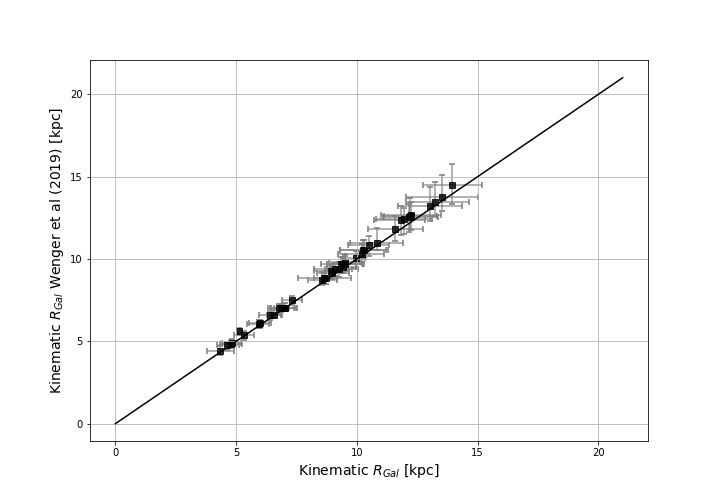

In [102]:
#Graficar:

fig, ax = plt.subplots(figsize = (10,7))

ax.plot(np.linspace(0,21), 1*np.linspace(0,21), c = 'k') #Linea Recta 
ax.errorbar(merged_df2['Rgal'], merged_df2['Rad'], xerr = [merged_df2['e_Rm'], merged_df2['e_Rp']], 
            yerr = [merged_df2['e_Rad'],merged_df2['E_Rad']], c = 'k', fmt = 's', capsize = 3, capthick = 2, 
            ecolor = 'gray', label = 'Data', alpha = 0.8, zorder = 1)
ax.set_xlabel(r'Kinematic $R_{Gal}$ [kpc]', size = 14)
ax.set_ylabel(r'Kinematic $R_{Gal}$ Wenger et al (2019) [kpc]', size = 14) 
ax.grid(True)
plt.show()
plt.savefig('Rgal_Wenger1_Comparation', dpi = 300)

<IPython.core.display.Javascript object>


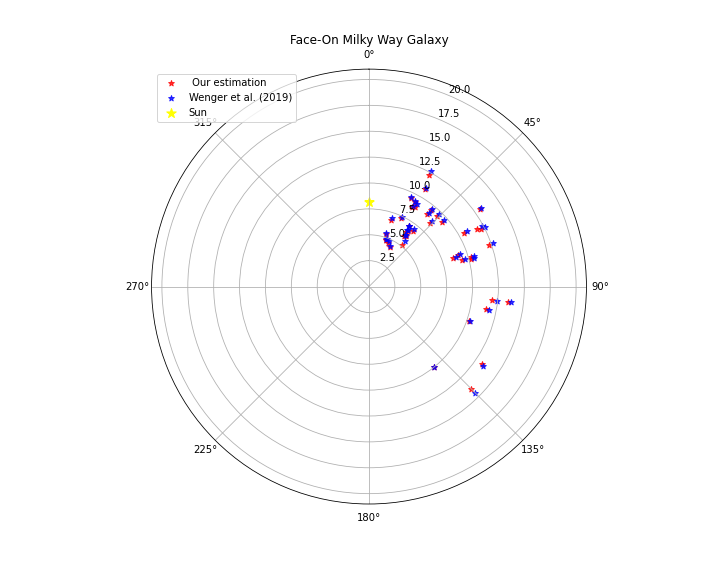

In [52]:
## Grafico Polar:

# Create a polar plot
fig, ax = plt.subplots(figsize = (10,8), subplot_kw={'projection': 'polar'})

r_1 = merged_df2['Rgal']
r_2 = merged_df2['Rad']
theta = np.deg2rad(merged_df2['GLON'])  # Adjust theta from the center
ax.scatter(theta, r_1, color='red', marker = '*', alpha = 0.8, label=' Our estimation')
ax.scatter(theta, r_2, color = 'blue', marker = '*', alpha = 0.8, label = 'Wenger et al. (2019)')
ax.scatter(0, 8.2, s = 100, marker = '*', color = 'yellow', label = 'Sun')


# Set title and labels
ax.set_theta_zero_location('N') 
ax.set_theta_direction(-1) 
ax.set_rlim(0,21)
ax.set_title("Face-On Milky Way Galaxy")
ax.legend(loc = 'upper left')


plt.show()
plt.savefig('Face-On_Wenger1', dpi = 300)

#### Segunda Muestra: Con esta vamos a hacer el gradiente

In [53]:
VIZIER_TAP_URL = 'http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap'
viz = TapPlus(url=VIZIER_TAP_URL)

table = "J/ApJ/887/114/table6" # change the table

job = viz.launch_job_async(
    f"""SELECT TOP 10000 *
    FROM 
        "{table}"
   """,
    output_format="csv",
)
tab = job.get_results()
Wenger3 = tab.to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]


In [54]:
#Mascara:

mask3 =  ~np.isnan(Wenger3['Dist'])

Wenger3 = Wenger3[mask3]
#Wenger3[(Wenger3['e_Rad'] == 0) & (Wenger3['E_Rad'] == 0) ]
Wenger3

,recno,Name,Tel,SL/SC,e_SL/SC,delV,e_delV,Te,e_Te,Type,...,E_Dist,f_Dist,Rad,e_Rad,E_Rad,f_Rad,Meth,r_Dist,_RA,_DE
0,1,G000.666-00.036,140 Foot,0.0569,0.0033,40.5,0.4,8170,180,NaN,...,0.84,NaN,0.21,0.11,0.91,NaN,P,R09c,266.834,-28.386
3,4,G005.900-00.431,140 Foot,0.0691,0.0006,22.5,0.2,11130,170,NaN,...,0.17,NaN,5.38,0.16,0.19,NaN,P,S14,270.171,-24.073
8,9,G010.596-00.381,VLA,0.1506,0.0015,23.1,0.2,5704,72,T,...,0.55,NaN,3.64,0.48,0.42,NaN,P,Sa14,272.602,-19.952
9,10,G012.804-00.207,140 Foot,0.0808,0.0007,30.7,0.3,7620,100,NaN,...,0.38,NaN,5.61,0.35,0.26,NaN,P,I13,273.562,-17.933
10,11,G013.880+00.285,VLA,0.1568,0.0004,21.5,0.1,5848,19,P,...,0.49,NaN,4.61,0.31,0.39,NaN,P,S14,273.649,-16.753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,172,G243.244+00.406,GBT,0.0793,0.0014,22.3,0.2,10477,214,NaN,...,0.98,NaN,10.84,0.52,0.73,NaN,K,NaN,118.178,-26.483
175,176,G348.710-01.044,140 Foot,0.1067,0.0008,24.6,0.2,7150,90,NaN,...,0.34,NaN,5.12,0.32,0.25,NaN,P,W12,260.022,-38.970
178,179,G351.246+00.673,VLA,0.1131,0.0003,25.1,0.1,6772,24,T,...,0.15,NaN,7.05,0.15,0.12,NaN,P,W14,260.074,-35.908
179,180,G351.311+00.663,VLA,0.1301,0.0004,24.1,0.1,6230,27,T,...,0.16,NaN,7.04,0.15,0.12,NaN,P,W14,260.130,-35.860


In [55]:
#Calcular Rgal:

R_Wenger_Total = R(Wenger3['_RA'].values, Wenger3['_DE'].values, Wenger3['Dist'].values, GC = 8.2)  #Quireza
Wenger3['Rgal'] = R_Wenger_Total

Wenger3 = Wenger3.reset_index(drop = True)

#Calculamos glong
l = np.array([])
coord_l = SkyCoord(Wenger3['_RA']*u.degree, Wenger3['_DE']*u.degree).galactic.l.value
l = np.append(l, coord_l)

#Calculamos glat
b = np.asarray([]) 
coord_b = SkyCoord(Wenger3['_RA']*u.degree, Wenger3['_DE']*u.degree).galactic.b.value
b = np.append(b, coord_b)

    
Wenger3['l'], Wenger3['b'] = l, b
Wenger3

,recno,Name,Tel,SL/SC,e_SL/SC,delV,e_delV,Te,e_Te,Type,...,e_Rad,E_Rad,f_Rad,Meth,r_Dist,_RA,_DE,Rgal,l,b
0,1,G000.666-00.036,140 Foot,0.0569,0.0033,40.5,0.4,8170,180,NaN,...,0.11,0.91,NaN,P,R09c,266.834,-28.386,0.616866,0.665672,-0.035849
1,4,G005.900-00.431,140 Foot,0.0691,0.0006,22.5,0.2,11130,170,NaN,...,0.16,0.19,NaN,P,S14,270.171,-24.073,5.235001,5.900119,-0.430416
2,9,G010.596-00.381,VLA,0.1506,0.0015,23.1,0.2,5704,72,T,...,0.48,0.42,NaN,P,Sa14,272.602,-19.952,3.528834,10.596645,-0.379700
3,10,G012.804-00.207,140 Foot,0.0808,0.0007,30.7,0.3,7620,100,NaN,...,0.35,0.26,NaN,P,I13,273.562,-17.933,5.476422,12.803621,-0.206167
4,11,G013.880+00.285,VLA,0.1568,0.0004,21.5,0.1,5848,19,P,...,0.31,0.39,NaN,P,S14,273.649,-16.753,4.611261,13.879833,0.284823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,172,G243.244+00.406,GBT,0.0793,0.0014,22.3,0.2,10477,214,NaN,...,0.52,0.73,NaN,K,NaN,118.178,-26.483,10.684774,243.244061,0.407457
162,176,G348.710-01.044,140 Foot,0.1067,0.0008,24.6,0.2,7150,90,NaN,...,0.32,0.25,NaN,P,W12,260.022,-38.970,4.987669,348.710315,-1.043880
163,179,G351.246+00.673,VLA,0.1131,0.0003,25.1,0.1,6772,24,T,...,0.15,0.12,NaN,P,W14,260.074,-35.908,6.908244,351.246132,0.673015
164,180,G351.311+00.663,VLA,0.1301,0.0004,24.1,0.1,6230,27,T,...,0.15,0.12,NaN,P,W14,260.130,-35.860,6.898135,351.311452,0.663197


In [56]:
#Calcular los errores:

e_RgalWenger2 = e_Rgal(Wenger3['l'], Wenger3['b'], Wenger3['Dist'], Wenger3['e_Dist'], Wenger3['E_Dist'])
[Wenger3['e_Rm'], Wenger3['e_Rp']] = e_RgalWenger2[0], e_RgalWenger2[1]

<IPython.core.display.Javascript object>


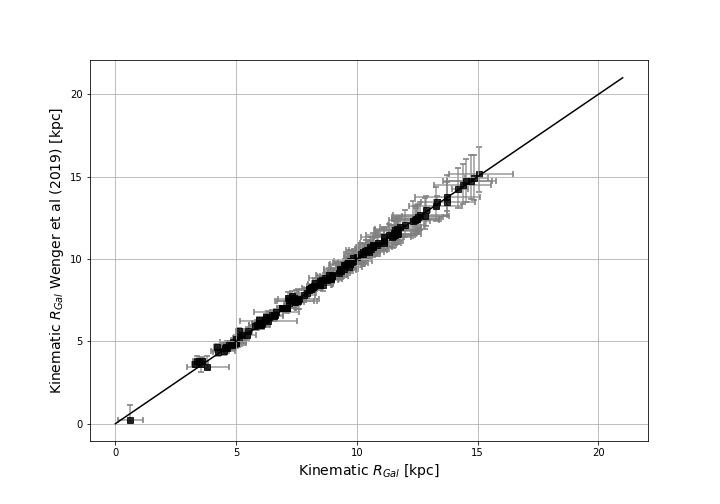

In [103]:
#Graficar:

fig, ax = plt.subplots(figsize = (10,7))

ax.plot(np.linspace(0,21), 1*np.linspace(0,21), c = 'k') #Linea Recta 
ax.errorbar(Wenger3['Rgal'], Wenger3['Rad'], xerr = [Wenger3['e_Rm'], Wenger3['e_Rp']],
            yerr = [Wenger3['e_Rad'], Wenger3['E_Rad']], c = 'k', fmt = 's', capsize = 3, capthick = 2, 
            ecolor = 'gray', label = 'Data', alpha = 0.8, zorder = 1)
ax.set_xlabel(r'Kinematic $R_{Gal}$ [kpc]', size = 14)
ax.set_ylabel(r'Kinematic $R_{Gal}$ Wenger et al (2019) [kpc]', size = 14)
ax.grid(True)
plt.show()
plt.savefig('Rgal_Wenger2_Comparation', dpi = 300)

<IPython.core.display.Javascript object>


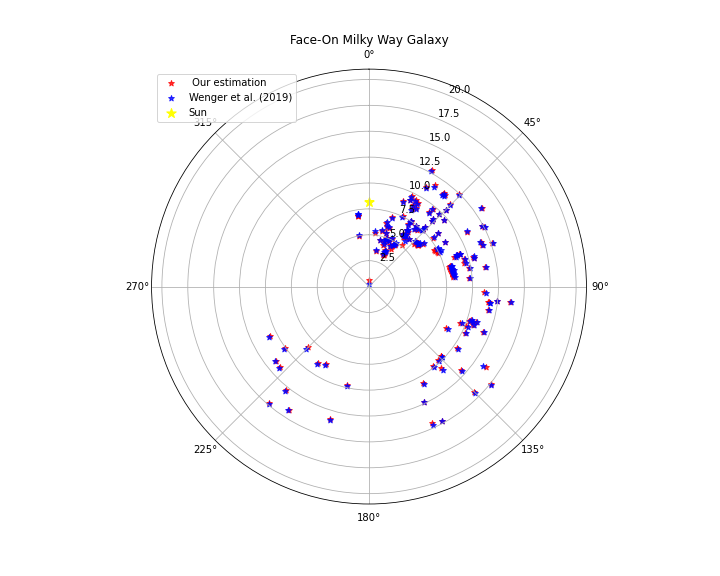

In [59]:
## Grafico Polar:

#Calculamos glong
l = np.array([])
coord_l = SkyCoord(Wenger3['_RA']*u.degree, Wenger3['_DE']*u.degree).galactic.l.value
l = np.append(l, coord_l)
Wenger3['GLON'] = l

# Create a polar plot
fig, ax = plt.subplots(figsize = (10,8), subplot_kw={'projection': 'polar'})

r_1 = Wenger3['Rgal']
r_2 = Wenger3['Rad']
theta =  np.deg2rad(Wenger3['GLON']) # Adjust theta from the center
ax.scatter(theta, r_1, color='red', marker = '*', alpha = 0.8, label=' Our estimation')
ax.scatter(theta, r_2, color = 'blue', marker = '*', alpha = 0.8, label = 'Wenger et al. (2019)')
ax.scatter(0, 8.2, s = 100, marker = '*', color = 'yellow', label = 'Sun')


# Set title and labels
ax.set_theta_zero_location('N') 
ax.set_theta_direction(-1) 
ax.set_rlim(0,21)
ax.set_title("Face-On Milky Way Galaxy")
ax.legend(loc = 'upper left')


plt.show()
plt.savefig('Face-On_Wenger2', dpi = 300)

### Khan:

In [60]:
Khan

,Name,GLONpeak,GLATpeak,Vlsr,e_Vlsr,Dsun,e_Dsun,RGC,_RA_icrs,_DE_icrs,Te,e_Te,Vrev,e_Vrev,d_SunNew,em_d,ep_d
0,G003.350-0.077,3.350,-0.077,7.80,1.13,2.90,0.29,5.43,268.421,-26.102,6.5,0.7,7.289886,2.449358,2.9430,0.80456,0.73656
1,G004.417+0.125,4.417,0.125,4.26,2.10,3.00,0.30,5.41,268.826,-25.079,6.6,1.0,4.921996,6.806409,NaN,NaN,NaN
2,G005.475-0.244,5.475,-0.244,21.45,0.99,11.90,1.19,3.87,269.762,-24.349,6.8,0.8,21.747132,5.008844,11.9825,0.67066,0.72546
3,G005.907-0.427,5.907,-0.427,8.83,0.30,1.76,0.74,6.40,270.171,-24.065,7.6,0.5,8.667046,2.733219,2.1940,0.62364,0.58400
4,G006.552-0.095,6.552,-0.095,11.96,0.30,14.10,1.41,6.07,270.206,-23.341,6.7,0.4,12.101006,2.447768,13.6985,0.51566,0.53330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,G080.886+0.425,80.886,0.425,-0.87,1.90,1.40,0.00,8.05,309.229,41.627,6.6,1.3,0.622641,4.949406,1.2980,0.01600,0.01700
211,G080.938-0.127,80.938,-0.127,-7.81,0.28,1.40,0.00,8.05,309.857,41.334,7.3,0.4,-7.282723,4.740610,1.2910,0.01500,0.01600
212,G080.940-0.267,80.940,-0.267,-5.50,2.13,1.40,0.00,8.05,310.007,41.250,8.6,1.8,-5.254762,5.067188,1.2920,0.01600,0.01700
213,G081.680+0.538,81.680,0.538,-1.47,0.29,1.40,0.00,8.07,309.755,42.327,8.0,0.4,-0.066310,1.558207,1.1870,0.01500,0.01300


In [61]:
### Vamos a quitar unos datos que hacen ruido segun Khan presentan una anomalia:
##" two H II regions stand out as anomalies, deviating from the overall trend in Te, exhibiting significantly lower 
#temperatures: G025.479–0.174 (with a temperature of 1010 K and located at a distance of 4.95 kpc) and G030.870–0.099 
#(with a temperature of 1441 K and located at a distance of 4.85 kpc)."

# Vamos a imprimir los index de los valores que vamos a eliminar:

print('Estos son los index para las regiones G025.479–0.174 y G030.870–0.099:', Khan.index[(Khan['Name'] == 'G025.479-0.174') | (Khan['Name'] =='G030.870-0.099')].tolist())

#print('Estos son los index para las regiones donde e_Dsun = 0:', Khan.index[(Khan['e_Dsun'] == 0)].tolist())

Khan2 = Khan.drop([97,137])
#Khan2 = Khan.drop(Khan.index[(Khan['e_Dsun'] == 0)])
print(len(Khan2))

Estos son los index para las regiones G025.479–0.174 y G030.870–0.099: [97, 137]
213


In [62]:
#Mascara: Se eliman los valores que tienen NaN en dSun_new
mask4 =  ~np.isnan(Khan2['Dsun'])
Khan2 = Khan2[mask4]

#Reset index:
Khan2 = Khan2.reset_index(drop = True)


#Calcular Rgal:

R_Khan = R(Khan2['_RA_icrs'].values, Khan2['_DE_icrs'].values, Khan2['Dsun'].values, GC  = 8.2) #Quireza
Khan2['Rgal'] = R_Khan
Khan2

,Name,GLONpeak,GLATpeak,Vlsr,e_Vlsr,Dsun,e_Dsun,RGC,_RA_icrs,_DE_icrs,Te,e_Te,Vrev,e_Vrev,d_SunNew,em_d,ep_d,Rgal
0,G003.350-0.077,3.350,-0.077,7.80,1.13,2.90,0.29,5.43,268.421,-26.102,6.5,0.7,7.289886,2.449358,2.9430,0.80456,0.73656,5.307665
1,G004.417+0.125,4.417,0.125,4.26,2.10,3.00,0.30,5.41,268.826,-25.079,6.6,1.0,4.921996,6.806409,NaN,NaN,NaN,5.214044
2,G005.475-0.244,5.475,-0.244,21.45,0.99,11.90,1.19,3.87,269.762,-24.349,6.8,0.8,21.747132,5.008844,11.9825,0.67066,0.72546,3.818655
3,G005.907-0.427,5.907,-0.427,8.83,0.30,1.76,0.74,6.40,270.171,-24.065,7.6,0.5,8.667046,2.733219,2.1940,0.62364,0.58400,6.451950
4,G006.552-0.095,6.552,-0.095,11.96,0.30,14.10,1.41,6.07,270.206,-23.341,6.7,0.4,12.101006,2.447768,13.6985,0.51566,0.53330,6.026643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,G080.886+0.425,80.886,0.425,-0.87,1.90,1.40,0.00,8.05,309.229,41.627,6.6,1.3,0.622641,4.949406,1.2980,0.01600,0.01700,8.097112
209,G080.938-0.127,80.938,-0.127,-7.81,0.28,1.40,0.00,8.05,309.857,41.334,7.3,0.4,-7.282723,4.740610,1.2910,0.01500,0.01600,8.098383
210,G080.940-0.267,80.940,-0.267,-5.50,2.13,1.40,0.00,8.05,310.007,41.250,8.6,1.8,-5.254762,5.067188,1.2920,0.01600,0.01700,8.098438
211,G081.680+0.538,81.680,0.538,-1.47,0.29,1.40,0.00,8.07,309.755,42.327,8.0,0.4,-0.066310,1.558207,1.1870,0.01500,0.01300,8.116508


In [63]:
# Función que determina Error en R_gal de Khan:

def e_R_Khan(RA, DEC, Dsun, e_Dsun):
    
    GC = 8.2 #Centro Galactico
    e_GC = 0.1 #Error en el Centro Galactico
    n_samples = 10000 #Número de muestras MonteCarlo

    #Listas vacias:

    e_Rm_list = [] #Arreglo vacio que almacenará los datos del error minus
    e_Rp_list = [] #Arreglo vacio que almacenará los datos del error plus
    
    # Check if input arrays have the same length
    if not (len(RA) == len(DEC) == len(Dsun) == len(e_Dsun)):
        raise ValueError("Input arrays must have the same length.")

    #Vamos a crear una serie de simulaciones MonteCarlo para cada row de nuestro dataframe:

    for i in range(len(Dsun)):         
    
        #Hacemos una simulación MonteCarlo de 2000 muestras para cada Row de nuestro dataframe
    
        Dsun_samples = np.absolute(np.random.normal(Dsun[i], e_Dsun[i], n_samples))#Simulación MonteCarlo para distancia Heliocentrica
        GC_samples = np.random.normal(GC, e_GC, n_samples) #Simulación MonteCarlo para error en la distancia al centro galactico
    
    
        #Calculos el Radio Galactocentrico:
    
        RGC_samples = R(RA[i], DEC[i], Dsun_samples, GC_samples).value #Llamamos a la función R para determinar el Radio Galactocentrico
        
        #RGC_samples = R_samples = np.sqrt( GC_samples**2 + Dsun_samples**2 - 2*GC_samples *Dsun_samples* np.cos(np.deg2rad(l[i]))*np.cos(np.deg2rad(b[i])) )
        
        x_eva = np.linspace(min(RGC_samples), max(RGC_samples), num = 1000) # Arreglo en R que será el x de nuestra KDE
        
        #Para Calcular PDF ajustamos KDE:
        #KDE_Dp = stats.gaussian_kde(RGC_samples) #KDE
        
        #pdf_values = KDE_Dp(x_eva)
        
        #El PICO de PDF:
        
        #peak_R = x_eva[np.argmax(pdf_values)] #Este nos dará el Valor Central de R
        peak_R = np.median(RGC_samples)
        
        # Calculate the CDF using KDE
        
        #cdf_values = np.cumsum(pdf_values)
        #cdf_values /= cdf_values[-1]  # Normalize to [0, 1]
        
        # Find 16th and 84th percentiles (lower and upper bounds)
        
        #lower_bound = x_eva[np.searchsorted(cdf_values, 0.16)]
        #upper_bound = x_eva[np.searchsorted(cdf_values, 0.84)]
        
        #Errores asimetricos:
    
        #e_Rm = peak_R - lower_bound
        #e_Rp = upper_bound - peak_R
        
        #Calcular los percentiles 16th y 84th
        
        R_16th = np.percentile(RGC_samples, 16)
        R_84th = np.percentile(RGC_samples, 84)
    
        #Errores asimetricos:
        e_Rm = peak_R - R_16th
        e_Rp = R_84th - peak_R
    
        #Concatenar:
    
        e_Rm_list = np.append(e_Rm_list, np.absolute(e_Rm))
        e_Rp_list = np.append(e_Rp_list, np.absolute(e_Rp))
    
    return e_Rm_list, e_Rp_list

In [64]:
#Calcular los errores:

e_RgalKhan = e_R_Khan(Khan2['GLONpeak'], Khan2['GLATpeak'], Khan2['Dsun'], Khan2['e_Dsun'])
[Khan2['e_Rm'], Khan2['e_Rp']] = e_RgalKhan[0], e_RgalKhan[1]

<ipython-input-104-60dfdf5b4711>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (10,7))


<IPython.core.display.Javascript object>


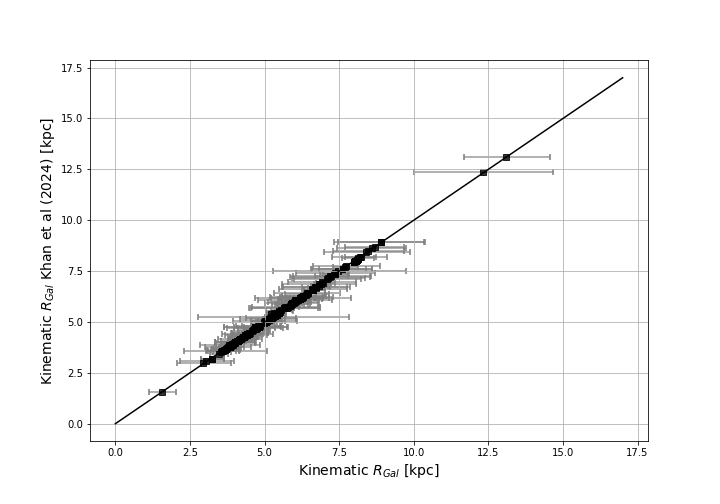

In [104]:
#Graficar:

fig, ax = plt.subplots(figsize = (10,7))

ax.plot(np.linspace(0,17), 1*np.linspace(0,17), c = 'k') #Linea Recta 
ax.errorbar(Khan2['Rgal'], Khan2['RGC'], xerr = [Khan2['e_Rm'], Khan2['e_Rp']],c = 'k', fmt = 's',
            capsize = 3, capthick = 2, ecolor = 'gray', label = 'Data', alpha = 0.8, zorder = 1)
ax.set_xlabel(r'Kinematic $R_{Gal}$ [kpc]', size = 14)
ax.set_ylabel(r'Kinematic $R_{Gal}$ Khan et al (2024) [kpc]', size =14)
ax.grid(True)
plt.show()
plt.savefig('Rgal_Khan_Comparation', dpi = 300)

<IPython.core.display.Javascript object>


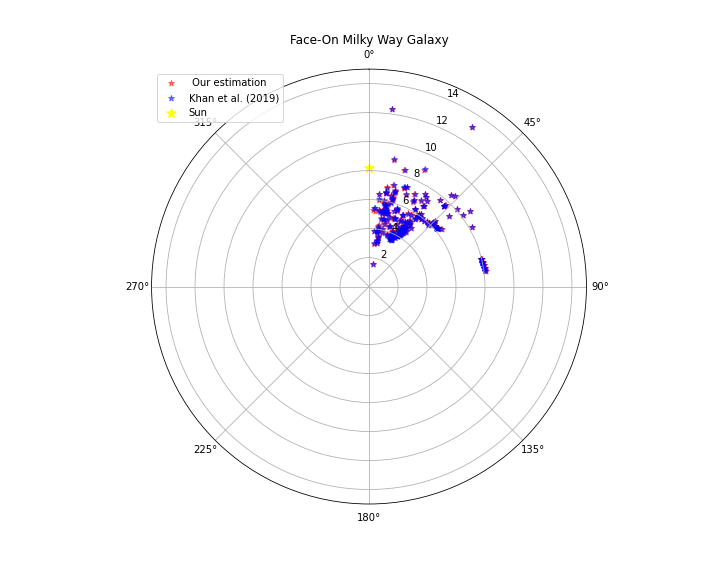

In [66]:
## Grafico Polar:

# Create a polar plot
fig, ax = plt.subplots(figsize = (10,8), subplot_kw={'projection': 'polar'})

r_1 = Khan2['Rgal']
r_2 = Khan2['RGC']
theta =  np.deg2rad(Khan2['GLONpeak']) # Adjust theta from the center
ax.scatter(theta, r_1, color='red', alpha = 0.5, marker = '*', label=' Our estimation')
ax.scatter(theta, r_2, color = 'blue', alpha = 0.5, marker = '*', label = 'Khan et al. (2019)')
ax.scatter(0, 8.2, s = 100, marker = '*', color = 'yellow', label = 'Sun')


# Set title and labels
ax.set_theta_zero_location('N') 
ax.set_theta_direction(-1) 
ax.set_rlim(0,15)
ax.set_title("Face-On Milky Way Galaxy")
ax.legend(loc = 'upper left')


plt.show()
plt.savefig('Face-On_Khan', dpi = 300)

In [67]:
Khan2

,Name,GLONpeak,GLATpeak,Vlsr,e_Vlsr,Dsun,e_Dsun,RGC,_RA_icrs,_DE_icrs,Te,e_Te,Vrev,e_Vrev,d_SunNew,em_d,ep_d,Rgal,e_Rm,e_Rp
0,G003.350-0.077,3.350,-0.077,7.80,1.13,2.90,0.29,5.43,268.421,-26.102,6.5,0.7,7.289886,2.449358,2.9430,0.80456,0.73656,5.307665,0.114526,0.125008
1,G004.417+0.125,4.417,0.125,4.26,2.10,3.00,0.30,5.41,268.826,-25.079,6.6,1.0,4.921996,6.806409,NaN,NaN,NaN,5.214044,0.127470,0.135126
2,G005.475-0.244,5.475,-0.244,21.45,0.99,11.90,1.19,3.87,269.762,-24.349,6.8,0.8,21.747132,5.008844,11.9825,0.67066,0.72546,3.818655,0.980939,1.036038
3,G005.907-0.427,5.907,-0.427,8.83,0.30,1.76,0.74,6.40,270.171,-24.065,7.6,0.5,8.667046,2.733219,2.1940,0.62364,0.58400,6.451950,0.213951,0.278774
4,G006.552-0.095,6.552,-0.095,11.96,0.30,14.10,1.41,6.07,270.206,-23.341,6.7,0.4,12.101006,2.447768,13.6985,0.51566,0.53330,6.026643,1.253599,1.227012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,G080.886+0.425,80.886,0.425,-0.87,1.90,1.40,0.00,8.05,309.229,41.627,6.6,1.3,0.622641,4.949406,1.2980,0.01600,0.01700,8.097112,0.000000,0.000000
209,G080.938-0.127,80.938,-0.127,-7.81,0.28,1.40,0.00,8.05,309.857,41.334,7.3,0.4,-7.282723,4.740610,1.2910,0.01500,0.01600,8.098383,0.000000,0.000000
210,G080.940-0.267,80.940,-0.267,-5.50,2.13,1.40,0.00,8.05,310.007,41.250,8.6,1.8,-5.254762,5.067188,1.2920,0.01600,0.01700,8.098438,0.000000,0.000000
211,G081.680+0.538,81.680,0.538,-1.47,0.29,1.40,0.00,8.07,309.755,42.327,8.0,0.4,-0.066310,1.558207,1.1870,0.01500,0.01300,8.116508,0.000000,0.000000


## GRADIENTE DE $T_e$ vs $R_{Gal}$ 

In [68]:
#Concatenar los datos a utilizar en un nuevo df_new2

#Khan:

Data_Khan = {'Name': Khan2['Name'],'R_Gal': Khan2['Rgal'], 'e_Rm': Khan2['e_Rm'], 'e_Rp': Khan2['e_Rp'], 'Te': Khan2['Te']*10**3 , 'e_Te': Khan2['e_Te']*10**3}
df_Khan = pd.DataFrame(Data_Khan)
print(len(df_Khan))

#Wenger:

Data_Wenger = {'Name': Wenger3['Name'], 'R_Gal': Wenger3['Rgal'], 'e_Rm': Wenger3['e_Rm'], 'e_Rp': Wenger3['e_Rp'], 'Te': Wenger3['Te'], 'e_Te': Wenger3['e_Te']}
df_Wenger = pd.DataFrame(Data_Wenger)
print(len(df_Wenger))

#Quireza:

Data_Quireza2 = {'Name': df_Quireza2['Name'], 'R_Gal': df_Quireza2['Rgal'], 'e_Rm': df_Quireza2['e_Rm'], 'e_Rp': df_Quireza2['e_Rp'], 'Te': df_Quireza2['Te'], 'e_Te': df_Quireza2['e_Te']}
df_Quireza3 = pd.DataFrame(Data_Quireza2)
print(len(df_Quireza2))

#Concatener:

df_new2 = pd.concat([df_Khan, df_Wenger, df_Quireza3])
df_new2.reset_index(inplace = True, drop = True)
df_new2
print(len(df_Wenger) + len(df_Khan) + len(df_Quireza3))

mask5 = ~np.isnan(df_new2['Te'])

df_new2 = df_new2[mask5]

df_new2

213
166
101
480


,Name,R_Gal,e_Rm,e_Rp,Te,e_Te
0,G003.350-0.077,5.307665,0.114526,0.125008,6500.0,700.0
1,G004.417+0.125,5.214044,0.127470,0.135126,6600.0,1000.0
2,G005.475-0.244,3.818655,0.980939,1.036038,6800.0,800.0
3,G005.907-0.427,6.451950,0.213951,0.278774,7600.0,500.0
4,G006.552-0.095,6.026643,1.253599,1.227012,6700.0,400.0
...,...,...,...,...,...,...
475,G353.08+0.36,6.991430,0.041906,0.123617,5390.0,100.0
476,G353.14+0.66,7.416643,1.156660,1.180767,6250.0,30.0
477,G353.186+0.8,7.214545,0.026107,0.086048,7100.0,40.0
478,G353.398-0.3,4.826222,0.266209,0.324654,8480.0,60.0


In [69]:
#df_new2['e_Rm'], df_new2['e_Rp'] = 0.1, 0.1

"""""
El nuevo metodo de calculo en los errores en las distancias considera el error en R0 lo cual genera que algunas regiones
en Khan et al 2024 no sean 0 como con el viejo metodo modificando los errores del gradiente, y como Khan a dichas regiones
les asigno manuelmente los errores en las distancias heliocentricas a 0 no las vamos a considerar en nuestro estudio
por ende, las vamos a despreciar
"""""

df_new2 = df_new2[ (df_new2['e_Te'] > 50) & (df_new2['e_Rm'] > 0) ]

#Reset index:

#Reset index:

df_new2 = df_new2.reset_index(drop = True)
print(len(df_new2))
df_new2

428


,Name,R_Gal,e_Rm,e_Rp,Te,e_Te
0,G003.350-0.077,5.307665,0.114526,0.125008,6500.0,700.0
1,G004.417+0.125,5.214044,0.127470,0.135126,6600.0,1000.0
2,G005.475-0.244,3.818655,0.980939,1.036038,6800.0,800.0
3,G005.907-0.427,6.451950,0.213951,0.278774,7600.0,500.0
4,G006.552-0.095,6.026643,1.253599,1.227012,6700.0,400.0
...,...,...,...,...,...,...
423,G351.69-1.17,5.852667,0.319150,0.353905,7560.0,90.0
424,G352.61-0.17,1.054504,0.061293,0.070630,7560.0,240.0
425,G353.08+0.36,6.991430,0.041906,0.123617,5390.0,100.0
426,G353.398-0.3,4.826222,0.266209,0.324654,8480.0,60.0


In [70]:
def linfit(x, x_em, x_ep, y, y_e): #
    #Defimos el error en x como el valor medio:
    
    x_e = (x_em + x_ep)/2
      
    #definimos la forma de la funcion que queremos ajustar
            
    def func(p, x):
        m,b = p
        return m*x + b
 
    quad_model = odr.Model(func)
    
    # Create a RealData object
    data = odr.RealData(x, y, sx = x_e, sy=y_e)

    # Set up ODR with the model and data.
    odr_instance = odr.ODR(data, quad_model, beta0=[0., 1.])

    # Run the regression.
    out = odr_instance.run()

    #print fit parameters, 1-sigma estimates & minimum chi-square
    popt = out.beta #Parametros 
    perr = out.sd_beta #Error
    chi_square_min = out.sum_square 
    
    v = len(x) - len(popt)  # Degrees of freedom (N - p, where p=2)

    # Reduced chi-square
    reduced_chi_square = chi_square_min/v


    c = popt[1]
    e_c = perr[1]
    
    m = popt[0]
    e_m = perr[0]

    # Calculate Pearson correlation coefficient
    correlation_coefficient, _ = stats.pearsonr(x, y)
    return  c, e_c, m, e_m, chi_square_min, reduced_chi_square, correlation_coefficient

In [71]:
ORD = linfit(df_new2['R_Gal'], df_new2['e_Rm'].values, df_new2['e_Rp'].values, df_new2['Te'], df_new2['e_Te'])

print(ORD)

x = np.linspace(0, 20, len(df_new2['R_Gal']))
y = ORD[0] + ORD[2]*x

(4330.4481649526015, 188.6940803994377, 516.1905309399856, 27.16208452328621, 12249.109612514, 28.753778433131455, 0.5847396912385688)


In [72]:
linre = stats.linregress(df_new2['R_Gal'], df_new2['Te'])
y2 = linre[0]*x + linre[1]
print(linre)

LinregressResult(slope=398.7318855132984, intercept=4741.501473712724, rvalue=0.5847396912385685, pvalue=1.2923390251464245e-40, stderr=26.801109413469835, intercept_stderr=200.6656086410827)


<IPython.core.display.Javascript object>


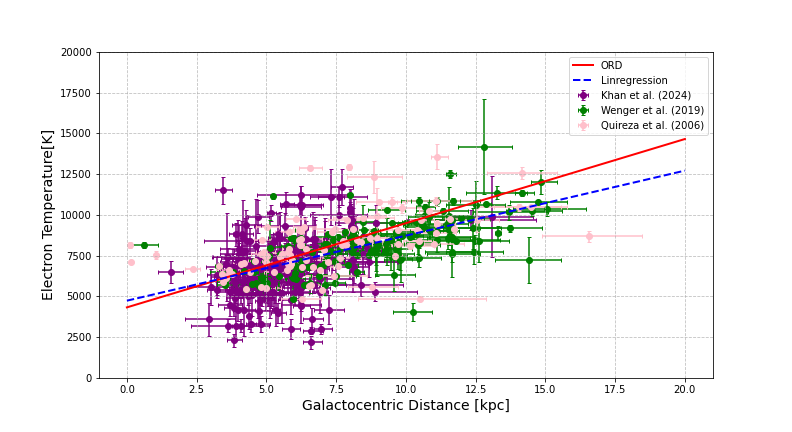

Slope ODR: 516.1905 ± 27.1621
Intercept ODR: 4330.4482 ± 188.6941
Slope Linregress:  398.7319 ± 26.8011
Intercept Linregress:  4741.5015 ± 199.8171


In [107]:
fig, ax = plt.subplots(figsize=(11,6))

ax.errorbar(df_Khan['R_Gal'].values, df_Khan['Te'], xerr = [df_Khan['e_Rm'], df_Khan['e_Rp']] , yerr= df_Khan['e_Te'], c = 'purple', capsize=2, fmt ='o', alpha = 1, label = 'Khan et al. (2024)', zorder =1)
ax.errorbar(df_Wenger['R_Gal'], df_Wenger['Te'], xerr = [df_Wenger['e_Rm'], df_Wenger['e_Rp']], yerr = df_Wenger['e_Te'], c = 'green',capsize=2, fmt ='o', alpha = 1, label = 'Wenger et al. (2019)', zorder = 1)
ax.errorbar(df_Quireza3['R_Gal'], df_Quireza3['Te'], xerr = [df_Quireza3['e_Rm'], df_Quireza3['e_Rp']],yerr = df_Quireza3['e_Te'], c = 'pink',capsize=2, fmt ='o', alpha = 1, label = 'Quireza et al. (2006)', zorder = 1)
#ax.errorbar(df_new2['R_Gal'], df_new2['Te'], xerr = [df_new2['e_Rm'], df_new2['e_Rp']], yerr = df_new2['e_Te'],c = 'k', 
 #           fmt = 's', capsize = 3, capthick = 2, ecolor = 'gray', label = 'Data', alpha = 0.7, zorder = 1)
plt.plot(x, y, c = 'r', label = 'ORD', lw = 2, zorder = 2)
plt.plot(x, y2, '--', c = 'b',lw = 2, label = 'Linregression', zorder = 2)

print(f"Slope ODR: {ORD[2]:.4f} ± {ORD[3]:.4f}")
print(f"Intercept ODR: {ORD[0]:.4f} ± {ORD[1]:.4f}")

print(f'Slope Linregress: {linre[0]: .4f} ± {linre[4]:.4f}')
print(f'Intercept Linregress: {linre[1]: .4f} ± {199.8171:.4f}')
ax.set_xlabel(r'Galactocentric Distance [kpc]', size = 14)
ax.set_ylabel(r'Electron Temperature[K]', size = 14)
plt.grid(True,linestyle='--', alpha = 0.8)
plt.legend()
plt.show()
#ax.set_xlim(0,20)
ax.set_ylim(0,20000)


plt.savefig('LinealFit_ElectronTemperature_Gradiente_New', dpi = 300)

In [86]:
#Save Dataframe
df_new2.to_csv("HIIRegions_RadioData.csv",index=False)

In [ ]:
### Vamos a observar la distribución de los datos:

fig, ax = plt.subplots(2,1,  figsize=(10,10))
bins = int(np.sqrt(len(df_new2['R_Gal'])))

ax[0].hist(df_new2['Te'], bins = bins, density=True,facecolor='white',edgecolor='black',lw=2, 
             alpha=1)

ax[1].hist(df_new2['R_Gal'], bins = bins, density=True,facecolor='white',edgecolor='black',lw=2, 
             alpha=1 )


for i in range(0,2):
    ax[i].set_ylabel(r'Number of Data')
    ax[i].set_xlabel(r'$Distribuction$')

Vamos a hacer dos nuevos ajustes usando Likelihood function trabajando bajo el framework de Least Squares (Dejaremos de lado por un momento ODR) uno solamente considerando errores en $y$ en otro considerando errores en ambos.

Para ello vamos a definir el log de la likelihood obteniendo el maximo (Maximum Likelihood) para obtener los mejores parametros para nuestro modelo; en el caso donde solamente trabajamos errores en y:

$$ \ln \left( \mathcal{L(\theta)} \right) = -\dfrac{1}{2} \sum_{i = i}^{N} { \left[ \dfrac{(y_i - f(x_i, \theta))^2}{\sigma_{y,i}^{2}} +  \ln(2\pi \sigma_{y,i}^{2})  \right] }$$
 

Para el caso donde tenemos errores tanto en $x$ como en $y$ tendremos el siguente caso:

$$ \ln \left( \mathcal{L(\theta)} \right) = -\dfrac{1}{2} \sum_{i = i}^{N} { \left[ \dfrac{(y_i - f(x_i, \theta))^2}{\sigma_{y,i}^{2} + m^2 \sigma_{x,i}^{2}} +  \ln(2\pi (\sigma_{y,i}^{2} + m^2 \sigma_{x,i}^{2}))  \right] }$$

Esta ultima es considerando un modelo lineal donde  $f(x, \theta) = mx +c $ 


De forma general podemos expresar nuestra Likelihood si nuestra función $f(x, \theta) $ depende solo de una varaible aletoria $x$ con varios parametros $\theta$ :

$$ \ln \left( \mathcal{L(\theta)} \right) = -\dfrac{1}{2} \sum_{i = i}^{N} { \left[ \dfrac{(y_i - f(x_i, \theta))^2}{\sigma_{y,i}^{2} + \left(\frac{\partial f}{\partial x_i}\sigma_{x,i} \right)^{2}} +  \ln \left[2\pi \left(\sigma_{y,i}^{2} + \left(\frac{\partial f}{\partial x_i}\sigma_{x,i} \right)^{2} \right) \right]  \right] }$$


OJO: Estas funciones asumen que las distribuciones de los datos siguen una distribución Gaussiana aletoria, dependiendo la forma de la distribución, las Likelihood function toman formas diferentes.

La estimación de las desviaciones estandar de nuestros parametros lo haremos con Markov chain Monte Carlo (MCMC), usando la libreria emcee: https://emcee.readthedocs.io/en/stable/

Tambien usaremos la libreria corner para visualizar nuestros resultados: https://corner.readthedocs.io/en/latest/

### Vamos a empezar consideramento unicamente errores en y:

In [ ]:
#Definimos nuestra likelihood:

def log_likelihood(theta, x, y, yerr):
    m, b= theta
    model = m * x + b
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2/sigma2 + np.log(2*np.pi*sigma2))

np.random.seed(128)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([10,10]) + 0.1* np.random.randn(2)
soln = minimize(nll, initial, args=(df_new2['R_Gal'], df_new2['Te'], df_new2['e_Te']))
m_ml, b_ml  = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))

Ahora vamos a estimar las desviaciones estandar usando emcee y visualizando con corner plots:

In [ ]:
#Definimos nuestros limites
def log_prior(theta):
    m, b= theta
    if 250 < m < 400 and  3500< b < 5500:
        return 0.0
    return -np.inf

#Combinando log_prior y log_likelihood obtenemos the full log-probability function:

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [ ]:
pos = soln.x + 1* np.random.randn(5000, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(df_new2['R_Gal'], df_new2['Te'], df_new2['e_Te'])
)
sampler.run_mcmc(pos, 500, progress=True);

In [ ]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Slope", "Intercept"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
flat_samples = sampler.get_chain(discard=10, thin=1, flat=True)
print(flat_samples.shape)

fig = corner.corner(flat_samples, labels=labels, truths=[m_ml, b_ml], show_titles = True, quantiles=(0.16, 0.84),
                    levels=(0.68,), title_kwargs={"fontsize": 12},color="C3", scale_hist = True);
fig.tight_layout(pad=1)

plt.savefig('CornerPlot_ML_Y_Te_vs_Rgal')

In [ ]:
#Gradiente:

fig, ax = plt.subplots(figsize=(11,6))

ax.errorbar(df_new2['R_Gal'], df_new2['Te'], xerr = [df_new2['e_Rm'], df_new2['e_Rp']], yerr = df_new2['e_Te'],c = 'k', 
            fmt = 'o', capsize = 3, capthick = 2, ecolor = 'gray', label = 'Data', alpha = 0.7, zorder = 1)

inds = np.random.randint(len(flat_samples), size=1000)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(df_new2['R_Gal'], np.dot(np.vander(df_new2['R_Gal'], 2), sample[:2]), "C1", c = 'Yellow', alpha=1, zorder =2)
plt.plot(x, (b_ml + m_ml*x), c = 'r', label = 'Maximum Likelihood ', zorder = 2)
ax.set_title("Gradiente de Temperatura Electronica")
ax.set_xlabel(r'Galactocentric Distance [$kpc$]')
ax.set_ylabel(r'Electron Temperature[$K$]')
plt.grid(True)
plt.legend()
plt.show()
ax.set_ylim(0,18000)
plt.savefig('LinealFit_ElectronTemperature_Gradiente_ML_Y', dpi = 1000)

### Ahora vamos a utilizar nuestra Likelihood considerando errores en x y en y:

In [ ]:
#Definimos nuestra nueva likelihood:

def log_likelihood_2(theta, x, y, yerr, em_x, ep_x):
    
    xerr = (em_x + ep_x)/2
    
    m, b= theta
    model = m * x + b
    sigma2 = (yerr**2 + (m*xerr)**2)
    return -0.5 * np.sum((y - model) ** 2/sigma2 + np.log(2*np.pi*sigma2))

np.random.seed(128)
nll2 = lambda *args: -log_likelihood_2(*args)
initial2 = np.array([1,1]) + 1* np.random.randn(2)
soln2 = minimize(nll2, initial2, args=(df_new2['R_Gal'], df_new2['Te'], df_new2['e_Te'], df_new2['e_Rm'], df_new2['e_Rp']))
m_ml2, b_ml2  = soln2.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml2))
print("b = {0:.3f}".format(b_ml2))

In [ ]:
#Definimos nuestros limites
def log_prior_2(theta):
    m, b= theta
    if 300 < m < 600 and  3500< b < 6500:
        return 0.0
    return -np.inf

#Combinando log_prior y log_likelihood obtenemos the full log-probability function:

def log_probability_2(theta, x, y, yerr, em_x, ep_x):
    lp = log_prior_2(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_2(theta, x, y, yerr, em_x, ep_x)

In [ ]:
pos2 = soln2.x + 1* np.random.randn(5000, 2)
nwalkers2, ndim2 = pos2.shape

sampler2 = emcee.EnsembleSampler(
    nwalkers2, ndim2, log_probability_2, args=(df_new2['R_Gal'], df_new2['Te'], df_new2['e_Te'], df_new2['e_Rm'], df_new2['e_Rp'])
)
sampler2.run_mcmc(pos2, 500, progress=True);

In [ ]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples2 = sampler2.get_chain()
labels2 = ["Slope", "Intercept"]
for i in range(ndim2):
    ax = axes[i]
    ax.plot(samples2[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples2))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
flat_samples2 = sampler2.get_chain(discard=10, thin=1, flat=True)
print(flat_samples2.shape)

fig = corner.corner(flat_samples2, labels=labels2, truths=[m_ml2, b_ml2],quantiles=(0.16, 0.84),levels=(0.68,),
                    show_titles = True, title_kwargs={"fontsize": 12},color="C3", scale_hist = True);
fig.tight_layout(pad=1)

plt.savefig('CornerPlot_ML_XY_Te_vs_Rgal', dpi = 1000)

In [ ]:
#Gradiente:

fig, ax = plt.subplots(figsize=(12,6))

ax.errorbar(df_new2['R_Gal'], df_new2['Te'], xerr = [df_new2['e_Rm'], df_new2['e_Rp']], yerr = df_new2['e_Te'],c = 'k', 
            fmt = 'o', capsize = 3, capthick = 2, ecolor = 'gray', label = 'Data', alpha = 0.7, zorder = 1)

ind2 = np.random.randint(len(flat_samples2), size=1000)
for ind2 in ind2:
    sample = flat_samples2[ind2]
    plt.plot(df_new2['R_Gal'], np.dot(np.vander(df_new2['R_Gal'], 2), sample[:2]), "C1", c = 'Yellow', 
             alpha=1, zorder =2)
plt.plot(x, (b_ml2 + m_ml2*x), c = 'r', label = 'Maximum Likelihood Estimation', zorder =2)
#plt.plot(x, y, '--', c = 'r', label = 'ODR', zorder =2)
ax.set_title("Gradiente de Temperatura Electronica")
ax.set_xlabel(r'Galactocentric Distance [$kpc$]')
ax.set_ylabel(r'Electron Temperature[$K$]')


plt.grid(True)
plt.legend()
plt.show()
ax.set_ylim(0,18000)
plt.savefig('LinealFit_ElectronTemperature_Gradiente_ML_XY', dpi = 1000)